## Stock Screener: Model Training and Evaluation

### Library Installation (if needed)

In [16]:
# Install libraries the first time
# ! conda install fastai::fastai conda-forge::yfinance pandas pathlib numpy

### Importing Required Libraries

In [17]:
from fastai.tabular.all import *
from fastai.metrics import rmse, mae
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pathlib

### Variables

In [18]:
# Model settings
modelName = 'stockScreenerV1.10'
trainingData = 'stockData.csv'
getNewData = False 
trainNewModel = True
predictionTarget = 'NVO'  # 'ALL' for all, 'amount%', 'None' for no prediction

# Training parameters
trainingSize = 2000  # Number of stocks to use for training
timeFrame = '10y'   # Options: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'
yNames = ['Future Year Change']
contNames = [
    'Open', 'Close', 'Volume', 'Dividends', 'Stock Splits',
    'EV/EBIT', 'ROIC']
catNames = ['Industry']
batchSize = 512
epochs = 43

# Testing parameters
testSize = 500  # Number of stocks to test, 'ALL' for all non-training stocks

# Paths
basePath = Path.cwd().parent
dataFolder = basePath / 'TrainingData'
modelFolder = basePath.parent / 'TrainedModels' / 'stockScreener'
testFolder = basePath / 'TestData'

## Data Preparation

#### Functions

In [19]:
def calculateFutureYearChange(ticker_symbol, timeframe, buffer=1):
    try:
        ticker = yf.Ticker(ticker_symbol)
        end_date = datetime.now().date()
        
        # Calculate required date range
        if timeframe == 'max':
            hist = ticker.history(period='max')
        else:
            years = int(timeframe[:-1])
            start_date = end_date - pd.DateOffset(years=years + buffer)
            
            # First check if ticker has existed long enough
            try:
                hist = ticker.history(start=start_date, end=end_date)
            except Exception as e:
                print(f"Data unavailable for {ticker_symbol} ({timeframe}): {e}")
                return pd.DataFrame()

        if hist.empty:
            print(f"No data found for {ticker_symbol} ({timeframe})")
            return pd.DataFrame()

        # Calculate future changes only if we have enough data points
        if len(hist) < 300:  # Minimum ~1.5 years of trading days
            print(f"Insufficient data for {ticker_symbol} ({len(hist)} rows)")
            return pd.DataFrame()

        # Calculate future price change
        hist['Future Year Change'] = (hist['Close'].shift(-252) / hist['Close'] - 1)
        hist = hist.dropna(subset=['Future Year Change'])
        
        return hist[['Open', 'Close', 'Volume', 'Dividends', 'Stock Splits', 
            'Future Year Change']].reset_index()

    except Exception as e:
        print(f"Error processing {ticker_symbol}: {str(e)}")
        return pd.DataFrame()

In [20]:
def calculateApproxEBIT(tickerSymbol):
    try:
        info = yf.Ticker(tickerSymbol).info
        revenue = info.get('totalRevenue', None)
        operatingIncome = info.get('operatingIncome', None)
        ebit = operatingIncome if operatingIncome else (revenue * 0.15 if revenue else None)
        return ebit if ebit and ebit != 0 else None  # Avoid zero division
    except Exception as e:
        return None

In [21]:
def enrichDataWithMetrics(histData):
    """Adds EV/EBIT and ROIC to the historical data."""
    # Initialize columns with NaN if they don't exist
    if 'EV/EBIT' not in histData.columns:
        histData['EV/EBIT'] = np.nan
    if 'ROIC' not in histData.columns:
        histData['ROIC'] = np.nan
    
    for ticker in histData['Ticker'].unique():
        try:
            evInfo = yf.Ticker(ticker).info
            totalDebt, cash, sharesOutstanding = evInfo.get('totalDebt', 0), evInfo.get('totalCash', 0), evInfo.get('sharesOutstanding', None)
            ebit = calculateApproxEBIT(ticker)

            if sharesOutstanding and ebit and ebit != 0:
                histData.loc[histData['Ticker'] == ticker, 'EV/EBIT'] = (
                    (histData['Close'] * sharesOutstanding + totalDebt - cash) / ebit
                )

                taxRate = 0.21
                nopat = ebit * (1 - taxRate)
                investedCapital = totalDebt + (histData['Close'] * sharesOutstanding) - cash
                histData.loc[histData['Ticker'] == ticker, 'ROIC'] = nopat / investedCapital
        except Exception as e:
            pass
    return histData

In [22]:
def getTickerDataFrom1YrAgo(ticker_symbol):
    try:
        # Fetch ticker data
        ticker = yf.Ticker(ticker_symbol)

        # Define the date range: one year ago to today
        today = datetime.today()
        one_year_ago = today - timedelta(days=365)

        # Fetch historical data for one year ago
        hist = ticker.history(start=(one_year_ago - timedelta(days=30)).strftime('%Y-%m-%d'), 
                              end=(one_year_ago + timedelta(days=0)).strftime('%Y-%m-%d'))
        if hist.empty:
            raise ValueError(f"No historical data available for {ticker_symbol} around {one_year_ago.strftime('%Y-%m-%d')}.")

        # Extract the closest data point to one year ago
        row = hist.iloc[0]  # Get the first available entry within the date range

        # Price today
        price_today = ticker.history(period='1d')['Close'].iloc[-1]

        # Calculate future price change (from one year ago to today)
        price_change_future = ((price_today - row['Close']) / row['Close']) if row['Close'] else None

        # Collect additional data
        evInfo = yf.Ticker(ticker_symbol).info
        total_debt, cash, shares_outstanding = evInfo.get('totalDebt', 0), evInfo.get('totalCash', 0), evInfo.get('sharesOutstanding', None)
        ebit = calculateApproxEBIT(ticker_symbol)
        ev = (row['Close'] * shares_outstanding) + total_debt - cash if shares_outstanding else None
        ev_ebit = ev / ebit if ebit else None
        market_cap = row['Close'] * shares_outstanding if shares_outstanding else None
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash if market_cap and total_debt and cash else None
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = yf.Ticker(ticker_symbol).info.get('industry', 'Unknown')

        # Return as a DataFrame
        return pd.DataFrame([{
            'Ticker': ticker_symbol,
            'Date': row.name,
            'Open': row['Open'],
            'High': row['High'],
            'Low': row['Low'],
            'Close': row['Close'],
            'Volume': row['Volume'],
            'Dividends': row.get('Dividends', 0.0),
            'Stock Splits': row.get('Stock Splits', 0.0),
            'Future Year Change': price_change_future,
            'Industry': industry,
            'EV/EBIT': ev_ebit,
            'ROIC': roic
        }])

    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return pd.DataFrame()

In [23]:
def getTickerData(ticker_symbol):
    try:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period='1d')
        evInfo = ticker.info
        total_debt, cash, shares_outstanding = evInfo.get('totalDebt', 0), evInfo.get('totalCash', 0), evInfo.get('sharesOutstanding', None)
        ebit = calculateApproxEBIT(ticker_symbol)
        ev = (hist['Close'].iloc[-1] * shares_outstanding) + total_debt - cash
        ev_ebit = ev / ebit if ebit else None
        market_cap = hist['Close'].iloc[-1] * shares_outstanding
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = yf.Ticker(ticker_symbol).info.get('industry', 'Unknown')
        
        # Add the 'Date' column
        date = datetime.now().strftime('%Y-%m-%d')

        return pd.DataFrame([{
            'Date': date,
            'Open': hist['Open'].iloc[-1],
            'High': hist['High'].iloc[-1],
            'Low': hist['Low'].iloc[-1],
            'Close': hist['Close'].iloc[-1],
            'Volume': hist['Volume'].iloc[-1],
            'Dividends': hist.get('Dividends', pd.Series([0.0])).iloc[-1],
            'Stock Splits': hist.get('Stock Splits', pd.Series([0.0])).iloc[-1],
            'EV/EBIT': ev_ebit,
            'Market Cap': market_cap,
            'ROIC': roic,
            'Industry': industry
        }])
    except Exception:
        return pd.DataFrame()

#### Download and Process Historical Data

In [24]:
tickers = pd.read_csv(testFolder / 'tickers.csv')['Ticker']
trainingTickers = np.random.choice(tickers, size=trainingSize, replace=False)

if getNewData:
    histData = pd.DataFrame()
    valid_tickers = []
    
    for ticker in trainingTickers:
        print(f"Processing {ticker}...")
        data = calculateFutureYearChange(ticker, timeFrame)
        if not data.empty:
            data['Ticker'] = ticker
            data['Industry'] = yf.Ticker(ticker).info.get('industry', 'Unknown')
            data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)
            
            # Enrich individual ticker data first
            ticker_data = enrichDataWithMetrics(data)
            histData = pd.concat([histData, ticker_data])
            
            # Check if metrics were added
            if 'ROIC' not in ticker_data.columns:
                print(f"WARNING: Failed to add metrics for {ticker}")
            
            valid_tickers.append(ticker)
        else:
            print(f"Skipped {ticker} - insufficient data")

    print(f"\nColumns in final dataset: {histData.columns.tolist()}")
    
    if not histData.empty:
        histData = enrichDataWithMetrics(histData)
        histData.to_csv(dataFolder / trainingData, index=True)
        # Verify no future targets leaked to past dates
        latest_date = pd.to_datetime(histData['Date']).max()
        if 'Future Year Change' in histData.columns:
            target_dates = histData[histData['Future Year Change'].notnull()]['Date']
            if any(pd.to_datetime(target_dates) > latest_date):
                raise ValueError("CRITICAL: Analyst targets contain future dates!")
        print(f"Saved training data with {len(histData)} rows")
    else:
        print("Warning: No data collected - check your tickers list")

## Model Training

In [25]:
if trainNewModel:
    TRAINING_CUTOFF = pd.to_datetime('2023-01-01')

    df = pd.read_csv(dataFolder / trainingData)
    dfCleaned = df.dropna(subset=['EV/EBIT', 'ROIC']).copy()

    # Convert 'Date' to datetime, parse UTC-aware dates, then make naive
    dfCleaned['Date'] = pd.to_datetime(dfCleaned['Date'], errors='coerce', utc=True).dt.tz_convert(None)
    dfCleaned = dfCleaned.dropna(subset=['Date'])

    # Clean 'EV/EBIT' and reset index
    dfCleaned['EV/EBIT'] = dfCleaned['EV/EBIT'].replace([np.inf, -np.inf], np.nan)
    dfCleaned = dfCleaned.dropna(subset=['EV/EBIT', 'ROIC'])
    dfCleaned = dfCleaned.reset_index(drop=True)
    dfCleaned.to_csv(dataFolder / trainingData, index=False)

    # Check for empty data
    if dfCleaned.empty:
        raise ValueError("The cleaned DataFrame is empty.")

    # Create splits with valid indices
    train_mask = dfCleaned['Date'] < TRAINING_CUTOFF
    valid_mask = ~train_mask
    splits = (list(dfCleaned[train_mask].index), list(dfCleaned[valid_mask].index))

    if not splits[0] or not splits[1]:
        raise ValueError("Empty training or validation split.")

    # Proceed with TabularPandas
    to = TabularPandas(
        dfCleaned, 
        procs=[Categorify, FillMissing, Normalize],
        y_names=yNames,
        cat_names=catNames, 
        cont_names=contNames,
        splits=splits
    )

    dls = to.dataloaders(bs=batchSize)

Learning rate finder results: lr_min=6.309573450380412e-08, lr_steep=1.0964781722577754e-06
Training for 43 epochs...


c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kw

epoch,train_loss,valid_loss,_rmse,mae,time
0,0.679205,2.523465,1.588542,0.421414,00:20
1,0.558505,4.473831,2.115143,0.406862,00:20
2,1.226950,1.389668,1.178841,0.433994,00:19
3,0.746505,1.255518,1.120499,0.406283,00:19
4,0.561822,1.137891,1.066719,0.401180,00:20
5,0.698328,1.114841,1.055860,0.383746,00:19
6,1.146562,1.293938,1.137514,0.428856,00:19
7,0.811267,2.441720,1.562600,0.419620,00:19
8,0.517364,1.379334,1.174450,0.387725,00:19
9,0.893550,1.136368,1.066006,0.399932,00:19


Model training complete


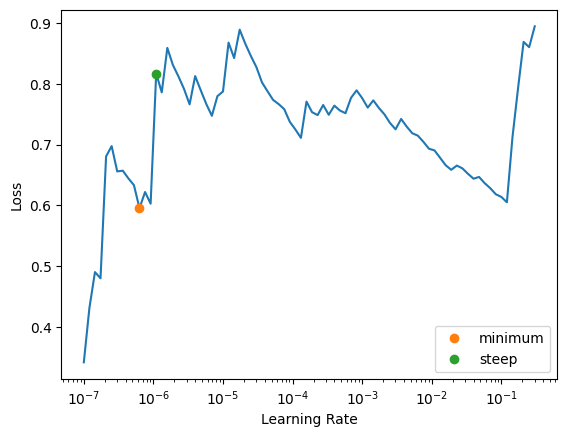

In [26]:
if trainNewModel:
    learn = tabular_learner(dls, metrics=[rmse, mae])

    # Learning rate finder
    lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

    # Debugging information
    print(f"Learning rate finder results: lr_min={lr_min}, lr_steep={lr_steep}")

    # Check if learning rates are valid
    if lr_min is None or lr_steep is None:
        raise ValueError("Learning rate finder did not return valid learning rates.")

    # Train
    print(f"Training for {epochs} epochs...")
    learn.fit_one_cycle(epochs, lr_max=lr_steep)
    print("Model training complete")

    learn.export(modelFolder / f'{modelName}.pkl')

## Testing and benchmarking

$USTR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$RUK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for USTR: No historical data available for USTR around 2024-01-28.
Error fetching data for RUK: No historical data available for RUK around 2024-01-28.


$FRC: possibly delisted; no timezone found


Error fetching data for FRC: No historical data available for FRC around 2024-01-28.


$GOV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GOV: No historical data available for GOV around 2024-01-28.


$INXB: possibly delisted; no timezone found


Error fetching data for INXB: No historical data available for INXB around 2024-01-28.


$SFI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SFI: No historical data available for SFI around 2024-01-28.


$JRJC: possibly delisted; no timezone found
$ENL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JRJC: No historical data available for JRJC around 2024-01-28.
Error fetching data for ENL: No historical data available for ENL around 2024-01-28.


$GENT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28) (Yahoo error = "Data doesn't exist for startDate = 1703826000, endDate = 1706418000")
$FFCO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$RSTI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GENT: No historical data available for GENT around 2024-01-28.
Error fetching data for FFCO: No historical data available for FFCO around 2024-01-28.
Error fetching data for RSTI: No historical data available for RSTI around 2024-01-28.


$KTP: possibly delisted; no timezone found
$STCK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KTP: No historical data available for KTP around 2024-01-28.
Error fetching data for STCK: No historical data available for STCK around 2024-01-28.


$LXP-C: possibly delisted; no timezone found


Error fetching data for LXP-C: No historical data available for LXP-C around 2024-01-28.


$IRET: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28) (Yahoo error = "Data doesn't exist for startDate = 1703826000, endDate = 1706418000")


Error fetching data for IRET: No historical data available for IRET around 2024-01-28.


$UBSH: possibly delisted; no timezone found


Error fetching data for UBSH: No historical data available for UBSH around 2024-01-28.


$FALC: possibly delisted; no price data found  (period=1d)


Error fetching data for FALC: single positional indexer is out-of-bounds


$EGN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$TLM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EGN: No historical data available for EGN around 2024-01-28.
Error fetching data for TLM: No historical data available for TLM around 2024-01-28.


$ELGX: possibly delisted; no timezone found


Error fetching data for ELGX: No historical data available for ELGX around 2024-01-28.


$JMBA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JMBA: No historical data available for JMBA around 2024-01-28.


$HMSY: possibly delisted; no timezone found


Error fetching data for HMSY: No historical data available for HMSY around 2024-01-28.


$SCTY: possibly delisted; no timezone found


Error fetching data for SCTY: No historical data available for SCTY around 2024-01-28.


$GGP-A: possibly delisted; no timezone found
$YOD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GGP-A: No historical data available for GGP-A around 2024-01-28.
Error fetching data for YOD: No historical data available for YOD around 2024-01-28.


$TRF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TRF: No historical data available for TRF around 2024-01-28.


$CSFS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CSFS: No historical data available for CSFS around 2024-01-28.


$HMTV: possibly delisted; no timezone found


Error fetching data for HMTV: No historical data available for HMTV around 2024-01-28.


$CISAW: possibly delisted; no timezone found


Error fetching data for CISAW: No historical data available for CISAW around 2024-01-28.


$LHCG: possibly delisted; no timezone found
$APRI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LHCG: No historical data available for LHCG around 2024-01-28.
Error fetching data for APRI: No historical data available for APRI around 2024-01-28.


$CEMP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$DDR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$AHS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CEMP: No historical data available for CEMP around 2024-01-28.
Error fetching data for DDR: No historical data available for DDR around 2024-01-28.
Error fetching data for AHS: No historical data available for AHS around 2024-01-28.


$TSRI: possibly delisted; no timezone found


Error fetching data for TSRI: No historical data available for TSRI around 2024-01-28.


$TOO-A: possibly delisted; no timezone found
$RNO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TOO-A: No historical data available for TOO-A around 2024-01-28.
Error fetching data for RNO: No historical data available for RNO around 2024-01-28.


$PSB-V: possibly delisted; no timezone found


Error fetching data for PSB-V: No historical data available for PSB-V around 2024-01-28.


$CIT: possibly delisted; no timezone found


Error fetching data for CIT: No historical data available for CIT around 2024-01-28.


$GTIV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$FLTX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GTIV: No historical data available for GTIV around 2024-01-28.
Error fetching data for FLTX: No historical data available for FLTX around 2024-01-28.


$BKI: possibly delisted; no timezone found


Error fetching data for BKI: No historical data available for BKI around 2024-01-28.


$MIE: possibly delisted; no timezone found


Error fetching data for MIE: No historical data available for MIE around 2024-01-28.


$EPB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EPB: No historical data available for EPB around 2024-01-28.


$HEOP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HEOP: No historical data available for HEOP around 2024-01-28.


$GSIG: possibly delisted; no price data found  (period=1d)


Error fetching data for GSIG: single positional indexer is out-of-bounds


$MET-A: possibly delisted; no timezone found


Error fetching data for MET-A: No historical data available for MET-A around 2024-01-28.


$CZFC: possibly delisted; no timezone found


Error fetching data for CZFC: No historical data available for CZFC around 2024-01-28.


$ALLB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ALLB: No historical data available for ALLB around 2024-01-28.


$MODN: possibly delisted; no timezone found
$ZLCS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MODN: No historical data available for MODN around 2024-01-28.
Error fetching data for ZLCS: No historical data available for ZLCS around 2024-01-28.


$LUX: possibly delisted; no price data found  (period=1d)


Error fetching data for LUX: single positional indexer is out-of-bounds


$SHOS: possibly delisted; no timezone found


Error fetching data for SHOS: No historical data available for SHOS around 2024-01-28.


$BPFH: possibly delisted; no timezone found


Error fetching data for BPFH: No historical data available for BPFH around 2024-01-28.


$TKMR: possibly delisted; no timezone found


Error fetching data for TKMR: No historical data available for TKMR around 2024-01-28.


$ESS-H: possibly delisted; no timezone found


Error fetching data for ESS-H: No historical data available for ESS-H around 2024-01-28.


$TUP: possibly delisted; no timezone found
$CIE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TUP: No historical data available for TUP around 2024-01-28.
Error fetching data for CIE: No historical data available for CIE around 2024-01-28.


$PBIP: possibly delisted; no timezone found


Error fetching data for PBIP: No historical data available for PBIP around 2024-01-28.


$BWC: possibly delisted; no timezone found
$EEME: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$BPO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BWC: No historical data available for BWC around 2024-01-28.
Error fetching data for EEME: No historical data available for EEME around 2024-01-28.
Error fetching data for BPO: No historical data available for BPO around 2024-01-28.


Failed to get ticker 'PSTI' reason: HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)
$PSTI: possibly delisted; no timezone found
$GTWN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PSTI: No historical data available for PSTI around 2024-01-28.
Error fetching data for GTWN: No historical data available for GTWN around 2024-01-28.


$MYM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$ZX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MYM: No historical data available for MYM around 2024-01-28.
Error fetching data for ZX: No historical data available for ZX around 2024-01-28.


$COBK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$AHL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$VCLK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for COBK: No historical data available for COBK around 2024-01-28.
Error fetching data for AHL: No historical data available for AHL around 2024-01-28.
Error fetching data for VCLK: No historical data available for VCLK around 2024-01-28.


$CBAK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CBAK: No historical data available for CBAK around 2024-01-28.


$TOO: possibly delisted; no timezone found


Error fetching data for TOO: No historical data available for TOO around 2024-01-28.


$SCU: possibly delisted; no timezone found
$CODE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SCU: No historical data available for SCU around 2024-01-28.
Error fetching data for CODE: No historical data available for CODE around 2024-01-28.


$HTWO: possibly delisted; no timezone found
$URS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$INXBU: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HTWO: No historical data available for HTWO around 2024-01-28.
Error fetching data for URS: No historical data available for URS around 2024-01-28.
Error fetching data for INXBU: No historical data available for INXBU around 2024-01-28.


$HGH: possibly delisted; no timezone found
$MENT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$OMG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HGH: No historical data available for HGH around 2024-01-28.
Error fetching data for MENT: No historical data available for MENT around 2024-01-28.
Error fetching data for OMG: No historical data available for OMG around 2024-01-28.


$PMBC: possibly delisted; no timezone found
$FBRC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PMBC: No historical data available for PMBC around 2024-01-28.
Error fetching data for FBRC: No historical data available for FBRC around 2024-01-28.


$SIBC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SIBC: No historical data available for SIBC around 2024-01-28.


$DDR-K: possibly delisted; no timezone found


Error fetching data for DDR-K: No historical data available for DDR-K around 2024-01-28.


$EPR-C: possibly delisted; no timezone found
$EVBS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EPR-C: No historical data available for EPR-C around 2024-01-28.
Error fetching data for EVBS: No historical data available for EVBS around 2024-01-28.


$PVTBP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$HGT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PVTBP: No historical data available for PVTBP around 2024-01-28.
Error fetching data for HGT: No historical data available for HGT around 2024-01-28.


$IIVI: possibly delisted; no timezone found


Error fetching data for IIVI: No historical data available for IIVI around 2024-01-28.


$NPV-E: possibly delisted; no timezone found


Error fetching data for NPV-E: No historical data available for NPV-E around 2024-01-28.


$GPS: possibly delisted; no timezone found


Error fetching data for GPS: No historical data available for GPS around 2024-01-28.


$CVG: possibly delisted; no price data found  (period=1d)


Error fetching data for CVG: single positional indexer is out-of-bounds


$IPCM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$STJ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IPCM: No historical data available for IPCM around 2024-01-28.
Error fetching data for STJ: No historical data available for STJ around 2024-01-28.


$CPST: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28) (Yahoo error = "Data doesn't exist for startDate = 1703826000, endDate = 1706418000")


Error fetching data for CPST: No historical data available for CPST around 2024-01-28.


$ANAD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ANAD: No historical data available for ANAD around 2024-01-28.


$GOM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GOM: No historical data available for GOM around 2024-01-28.


$SPN: possibly delisted; no timezone found


Error fetching data for SPN: No historical data available for SPN around 2024-01-28.


$MCA: possibly delisted; no timezone found


Error fetching data for MCA: No historical data available for MCA around 2024-01-28.


$DTZ: possibly delisted; no timezone found


Error fetching data for DTZ: No historical data available for DTZ around 2024-01-28.


$BLL: possibly delisted; no timezone found
$HBHC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BLL: No historical data available for BLL around 2024-01-28.
Error fetching data for HBHC: No historical data available for HBHC around 2024-01-28.


$ISP: possibly delisted; no price data found  (period=1d)


Error fetching data for ISP: single positional indexer is out-of-bounds


$PUK-A: possibly delisted; no timezone found


Error fetching data for PUK-A: No historical data available for PUK-A around 2024-01-28.


$PTNT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PTNT: No historical data available for PTNT around 2024-01-28.


$BZU: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BZU: No historical data available for BZU around 2024-01-28.


$OAS: possibly delisted; no timezone found


Error fetching data for OAS: No historical data available for OAS around 2024-01-28.
Error fetching data for CHSCP: unsupported operand type(s) for /: 'NoneType' and 'float'


$ECT: possibly delisted; no timezone found


Error fetching data for ECT: No historical data available for ECT around 2024-01-28.


$GFED: possibly delisted; no timezone found


Error fetching data for GFED: No historical data available for GFED around 2024-01-28.


$LIFE: possibly delisted; no timezone found


Error fetching data for LIFE: No historical data available for LIFE around 2024-01-28.


$LINTB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LINTB: No historical data available for LINTB around 2024-01-28.


$SNHN: possibly delisted; no timezone found
$KIOR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SNHN: No historical data available for SNHN around 2024-01-28.
Error fetching data for KIOR: No historical data available for KIOR around 2024-01-28.


$NS: possibly delisted; no timezone found


Error fetching data for NS: No historical data available for NS around 2024-01-28.


$DGICB: possibly delisted; no price data found  (period=1d)


Error fetching data for DGICB: single positional indexer is out-of-bounds


$WFBI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for WFBI: No historical data available for WFBI around 2024-01-28.


$BCF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BCF: No historical data available for BCF around 2024-01-28.


$SEAS: possibly delisted; no timezone found
$ULTR: possibly delisted; no price data found  (period=1d)


Error fetching data for SEAS: No historical data available for SEAS around 2024-01-28.
Error fetching data for ULTR: single positional indexer is out-of-bounds


$NTG: possibly delisted; no price data found  (period=1d)
$HTS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NTG: single positional indexer is out-of-bounds
Error fetching data for HTS: No historical data available for HTS around 2024-01-28.


$AGC: possibly delisted; no timezone found


Error fetching data for AGC: No historical data available for AGC around 2024-01-28.


$IRE-B: possibly delisted; no timezone found


Error fetching data for IRE-B: No historical data available for IRE-B around 2024-01-28.


$WSTG: possibly delisted; no timezone found


Error fetching data for WSTG: No historical data available for WSTG around 2024-01-28.


$AMAG: possibly delisted; no timezone found


Error fetching data for AMAG: No historical data available for AMAG around 2024-01-28.


$KELYB: possibly delisted; no price data found  (period=1d)
$JGG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KELYB: single positional indexer is out-of-bounds
Error fetching data for JGG: No historical data available for JGG around 2024-01-28.


$LTRE: possibly delisted; no price data found  (period=1d)


Error fetching data for LTRE: single positional indexer is out-of-bounds


$MEILZ: possibly delisted; no timezone found
$ADRU: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MEILZ: No historical data available for MEILZ around 2024-01-28.
Error fetching data for ADRU: No historical data available for ADRU around 2024-01-28.


$SRT: possibly delisted; no timezone found
$BAGR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SRT: No historical data available for SRT around 2024-01-28.
Error fetching data for BAGR: No historical data available for BAGR around 2024-01-28.


$JLA: possibly delisted; no timezone found


Error fetching data for JLA: No historical data available for JLA around 2024-01-28.


$GAM-B: possibly delisted; no timezone found
$PCP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GAM-B: No historical data available for GAM-B around 2024-01-28.
Error fetching data for PCP: No historical data available for PCP around 2024-01-28.


$NTC-D: possibly delisted; no timezone found
$NCP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$HXM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NTC-D: No historical data available for NTC-D around 2024-01-28.
Error fetching data for NCP: No historical data available for NCP around 2024-01-28.
Error fetching data for HXM: No historical data available for HXM around 2024-01-28.


$RALY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RALY: No historical data available for RALY around 2024-01-28.


$BML-H: possibly delisted; no timezone found


Error fetching data for BML-H: No historical data available for BML-H around 2024-01-28.


$RITT: possibly delisted; no price data found  (period=1d)
$CMLP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RITT: single positional indexer is out-of-bounds
Error fetching data for CMLP: No historical data available for CMLP around 2024-01-28.


$ISF: possibly delisted; no timezone found


Error fetching data for ISF: No historical data available for ISF around 2024-01-28.


$CTIC: possibly delisted; no timezone found
$FHCO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CTIC: No historical data available for CTIC around 2024-01-28.
Error fetching data for FHCO: No historical data available for FHCO around 2024-01-28.


$ANH: possibly delisted; no timezone found
$BBNK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ANH: No historical data available for ANH around 2024-01-28.
Error fetching data for BBNK: No historical data available for BBNK around 2024-01-28.


$NAV: possibly delisted; no timezone found


Error fetching data for NAV: No historical data available for NAV around 2024-01-28.


$ISLE: possibly delisted; no timezone found


Error fetching data for ISLE: No historical data available for ISLE around 2024-01-28.


$PKH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$DVR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PKH: No historical data available for PKH around 2024-01-28.
Error fetching data for DVR: No historical data available for DVR around 2024-01-28.


$CLCT: possibly delisted; no timezone found


Error fetching data for CLCT: No historical data available for CLCT around 2024-01-28.


$SORL: possibly delisted; no timezone found
$CPN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SORL: No historical data available for SORL around 2024-01-28.
Error fetching data for CPN: No historical data available for CPN around 2024-01-28.


$IMMY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$IMRS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IMMY: No historical data available for IMMY around 2024-01-28.
Error fetching data for IMRS: No historical data available for IMRS around 2024-01-28.


$AMAP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AMAP: No historical data available for AMAP around 2024-01-28.


$TGP: possibly delisted; no timezone found


Error fetching data for TGP: No historical data available for TGP around 2024-01-28.


$IBCPO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IBCPO: No historical data available for IBCPO around 2024-01-28.


$PEOP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PEOP: No historical data available for PEOP around 2024-01-28.


$PSA-P: possibly delisted; no timezone found
$GXP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PSA-P: No historical data available for PSA-P around 2024-01-28.
Error fetching data for GXP: No historical data available for GXP around 2024-01-28.


$IPHS: possibly delisted; no timezone found


Error fetching data for IPHS: No historical data available for IPHS around 2024-01-28.


$PFK: possibly delisted; no timezone found


Error fetching data for PFK: No historical data available for PFK around 2024-01-28.


$MBT: possibly delisted; no timezone found


Error fetching data for MBT: No historical data available for MBT around 2024-01-28.


$TCB.W: possibly delisted; no timezone found


Error fetching data for TCB.W: No historical data available for TCB.W around 2024-01-28.


$ROICW: possibly delisted; no timezone found


Error fetching data for ROICW: No historical data available for ROICW around 2024-01-28.


$BRE-D: possibly delisted; no timezone found


Error fetching data for BRE-D: No historical data available for BRE-D around 2024-01-28.


$NEE-I: possibly delisted; no timezone found
$JPZ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NEE-I: No historical data available for NEE-I around 2024-01-28.
Error fetching data for JPZ: No historical data available for JPZ around 2024-01-28.


$CLNY: possibly delisted; no timezone found


Error fetching data for CLNY: No historical data available for CLNY around 2024-01-28.


$OSN: possibly delisted; no timezone found


Error fetching data for OSN: No historical data available for OSN around 2024-01-28.


$HOS: possibly delisted; no timezone found


Error fetching data for HOS: No historical data available for HOS around 2024-01-28.


$ACCL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ACCL: No historical data available for ACCL around 2024-01-28.


$AREX: possibly delisted; no timezone found


Error fetching data for AREX: No historical data available for AREX around 2024-01-28.


$PWX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$SIFI: possibly delisted; no price data found  (period=1d)


Error fetching data for PWX: No historical data available for PWX around 2024-01-28.
Error fetching data for SIFI: single positional indexer is out-of-bounds


$TDA: possibly delisted; no timezone found


Error fetching data for TDA: No historical data available for TDA around 2024-01-28.


$NCU-C: possibly delisted; no timezone found


Error fetching data for NCU-C: No historical data available for NCU-C around 2024-01-28.


$MYC: possibly delisted; no timezone found
$PPO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MYC: No historical data available for MYC around 2024-01-28.
Error fetching data for PPO: No historical data available for PPO around 2024-01-28.


$CPSL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28) (Yahoo error = "Data doesn't exist for startDate = 1703826000, endDate = 1706418000")


Error fetching data for CPSL: No historical data available for CPSL around 2024-01-28.


$SJR: possibly delisted; no timezone found


Error fetching data for SJR: No historical data available for SJR around 2024-01-28.


$CFX: possibly delisted; no timezone found


Error fetching data for CFX: No historical data available for CFX around 2024-01-28.


$PTX: possibly delisted; no timezone found
$CRRB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PTX: No historical data available for PTX around 2024-01-28.
Error fetching data for CRRB: No historical data available for CRRB around 2024-01-28.


$WBB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$KIPS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for WBB: No historical data available for WBB around 2024-01-28.
Error fetching data for KIPS: No historical data available for KIPS around 2024-01-28.


$MSFG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$ALXA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MSFG: No historical data available for MSFG around 2024-01-28.
Error fetching data for ALXA: No historical data available for ALXA around 2024-01-28.


$BIOD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BIOD: No historical data available for BIOD around 2024-01-28.


$GCV-B: possibly delisted; no timezone found
$CHKE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GCV-B: No historical data available for GCV-B around 2024-01-28.
Error fetching data for CHKE: No historical data available for CHKE around 2024-01-28.


$KS: possibly delisted; no price data found  (period=1d)


Error fetching data for KS: single positional indexer is out-of-bounds


$TSC: possibly delisted; no timezone found
$MRF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TSC: No historical data available for TSC around 2024-01-28.
Error fetching data for MRF: No historical data available for MRF around 2024-01-28.


$DXYN: possibly delisted; no price data found  (period=1d)


Error fetching data for DXYN: single positional indexer is out-of-bounds


$HAYN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28) (Yahoo error = "No data found, symbol may be delisted")
$PRXI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HAYN: No historical data available for HAYN around 2024-01-28.
Error fetching data for PRXI: No historical data available for PRXI around 2024-01-28.


$JOY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JOY: No historical data available for JOY around 2024-01-28.


$BXP-B: possibly delisted; no timezone found


Error fetching data for BXP-B: No historical data available for BXP-B around 2024-01-28.


$HMA: possibly delisted; no timezone found
$HIH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HMA: No historical data available for HMA around 2024-01-28.
Error fetching data for HIH: No historical data available for HIH around 2024-01-28.


$LIQD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LIQD: No historical data available for LIQD around 2024-01-28.


$FSCFL: possibly delisted; no timezone found


Error fetching data for FSCFL: No historical data available for FSCFL around 2024-01-28.


$BPFHP: possibly delisted; no timezone found


Error fetching data for BPFHP: No historical data available for BPFHP around 2024-01-28.


$BKCC: possibly delisted; no timezone found


Error fetching data for BKCC: No historical data available for BKCC around 2024-01-28.


$TSS: possibly delisted; no timezone found


Error fetching data for TSS: No historical data available for TSS around 2024-01-28.


$UIHC: possibly delisted; no timezone found


Error fetching data for UIHC: No historical data available for UIHC around 2024-01-28.


$UBP: possibly delisted; no timezone found
$GJK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for UBP: No historical data available for UBP around 2024-01-28.
Error fetching data for GJK: No historical data available for GJK around 2024-01-28.


$MCBK: possibly delisted; no price data found  (period=1d)


Error fetching data for MCBK: single positional indexer is out-of-bounds


$MSCA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$ACUR: possibly delisted; no price data found  (period=1d)


Error fetching data for MSCA: No historical data available for MSCA around 2024-01-28.
Error fetching data for ACUR: single positional indexer is out-of-bounds


$CSFL: possibly delisted; no timezone found


Error fetching data for CSFL: No historical data available for CSFL around 2024-01-28.


$HCAP: possibly delisted; no timezone found
$HCLP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$ACW: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HCAP: No historical data available for HCAP around 2024-01-28.
Error fetching data for HCLP: No historical data available for HCLP around 2024-01-28.
Error fetching data for ACW: No historical data available for ACW around 2024-01-28.


$RVLT: possibly delisted; no timezone found
$IFEU: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RVLT: No historical data available for RVLT around 2024-01-28.
Error fetching data for IFEU: No historical data available for IFEU around 2024-01-28.


$FMBI: possibly delisted; no timezone found


Error fetching data for FMBI: No historical data available for FMBI around 2024-01-28.


$VCBI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for VCBI: No historical data available for VCBI around 2024-01-28.


$MRH-A: possibly delisted; no timezone found
$MLU: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$DMND: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MRH-A: No historical data available for MRH-A around 2024-01-28.
Error fetching data for MLU: No historical data available for MLU around 2024-01-28.
Error fetching data for DMND: No historical data available for DMND around 2024-01-28.


$REIS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for REIS: No historical data available for REIS around 2024-01-28.


$CBMXW: possibly delisted; no timezone found


Error fetching data for CBMXW: No historical data available for CBMXW around 2024-01-28.


$HOVU: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HOVU: No historical data available for HOVU around 2024-01-28.


$BSTC: possibly delisted; no timezone found


Error fetching data for BSTC: No historical data available for BSTC around 2024-01-28.


$ALIM: possibly delisted; no timezone found


Error fetching data for ALIM: No historical data available for ALIM around 2024-01-28.


$AKO.B: possibly delisted; no timezone found
$PF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$SGNT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AKO.B: No historical data available for AKO.B around 2024-01-28.
Error fetching data for PF: No historical data available for PF around 2024-01-28.
Error fetching data for SGNT: No historical data available for SGNT around 2024-01-28.


$VRNGW: possibly delisted; no timezone found


Error fetching data for VRNGW: No historical data available for VRNGW around 2024-01-28.


$CECE: possibly delisted; no timezone found


Error fetching data for CECE: No historical data available for CECE around 2024-01-28.


$AXS-C: possibly delisted; no timezone found


Error fetching data for AXS-C: No historical data available for AXS-C around 2024-01-28.


$SHPG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$HW: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SHPG: No historical data available for SHPG around 2024-01-28.
Error fetching data for HW: No historical data available for HW around 2024-01-28.


$RBS-L: possibly delisted; no timezone found


Error fetching data for RBS-L: No historical data available for RBS-L around 2024-01-28.


$MNTX: possibly delisted; no price data found  (period=1d)


Error fetching data for MNTX: single positional indexer is out-of-bounds


$LMNX: possibly delisted; no timezone found


Error fetching data for LMNX: No historical data available for LMNX around 2024-01-28.


$CAJ: possibly delisted; no timezone found


Error fetching data for CAJ: No historical data available for CAJ around 2024-01-28.


$BRK.A: possibly delisted; no timezone found


Error fetching data for BRK.A: No historical data available for BRK.A around 2024-01-28.


$CTU: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CTU: No historical data available for CTU around 2024-01-28.


$AIXG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AIXG: No historical data available for AIXG around 2024-01-28.


$MEN: possibly delisted; no timezone found


Error fetching data for MEN: No historical data available for MEN around 2024-01-28.


$ZIOP: possibly delisted; no timezone found


Error fetching data for ZIOP: No historical data available for ZIOP around 2024-01-28.


$ACAS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ACAS: No historical data available for ACAS around 2024-01-28.


$NXTM: possibly delisted; no timezone found


Error fetching data for NXTM: No historical data available for NXTM around 2024-01-28.


$JMF: possibly delisted; no timezone found


Error fetching data for JMF: No historical data available for JMF around 2024-01-28.


$SUMR: possibly delisted; no timezone found
$LNBB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$INZ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SUMR: No historical data available for SUMR around 2024-01-28.
Error fetching data for LNBB: No historical data available for LNBB around 2024-01-28.
Error fetching data for INZ: No historical data available for INZ around 2024-01-28.


$ONTX: possibly delisted; no timezone found


Error fetching data for ONTX: No historical data available for ONTX around 2024-01-28.


$DCUA: possibly delisted; no timezone found


Error fetching data for DCUA: No historical data available for DCUA around 2024-01-28.


$MAYS: possibly delisted; no price data found  (period=1d)


Error fetching data for MAYS: single positional indexer is out-of-bounds


$NUCL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NUCL: No historical data available for NUCL around 2024-01-28.


$NWLI: possibly delisted; no timezone found


Error fetching data for NWLI: No historical data available for NWLI around 2024-01-28.


$ACFC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$GFIG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ACFC: No historical data available for ACFC around 2024-01-28.
Error fetching data for GFIG: No historical data available for GFIG around 2024-01-28.


$DYNT: possibly delisted; no price data found  (period=1d)


Error fetching data for DYNT: single positional indexer is out-of-bounds


$FIRE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FIRE: No historical data available for FIRE around 2024-01-28.


$SYKE: possibly delisted; no timezone found
$COGO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$DFT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SYKE: No historical data available for SYKE around 2024-01-28.
Error fetching data for COGO: No historical data available for COGO around 2024-01-28.
Error fetching data for DFT: No historical data available for DFT around 2024-01-28.


$WIBC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for WIBC: No historical data available for WIBC around 2024-01-28.


$NSR: possibly delisted; no timezone found


Error fetching data for NSR: No historical data available for NSR around 2024-01-28.


$CGG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CGG: No historical data available for CGG around 2024-01-28.


$PPR: possibly delisted; no timezone found


Error fetching data for PPR: No historical data available for PPR around 2024-01-28.


$GTXI: possibly delisted; no timezone found


Error fetching data for GTXI: No historical data available for GTXI around 2024-01-28.


$BKYF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BKYF: No historical data available for BKYF around 2024-01-28.


$INWK: possibly delisted; no timezone found


Error fetching data for INWK: No historical data available for INWK around 2024-01-28.


$BEE-B: possibly delisted; no timezone found


Error fetching data for BEE-B: No historical data available for BEE-B around 2024-01-28.


$RBS-R: possibly delisted; no timezone found
$PBIB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RBS-R: No historical data available for RBS-R around 2024-01-28.
Error fetching data for PBIB: No historical data available for PBIB around 2024-01-28.


$ENG: possibly delisted; no price data found  (period=1d)


Error fetching data for ENG: single positional indexer is out-of-bounds


$JBJ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JBJ: No historical data available for JBJ around 2024-01-28.


$INT: possibly delisted; no timezone found


Error fetching data for INT: No historical data available for INT around 2024-01-28.


$WAFDW: possibly delisted; no timezone found


Error fetching data for WAFDW: No historical data available for WAFDW around 2024-01-28.


$CKEC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CKEC: No historical data available for CKEC around 2024-01-28.


$FST: possibly delisted; no timezone found
$PYG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$DEG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FST: No historical data available for FST around 2024-01-28.
Error fetching data for PYG: No historical data available for PYG around 2024-01-28.
Error fetching data for DEG: No historical data available for DEG around 2024-01-28.


$PL-E: possibly delisted; no timezone found


Error fetching data for PL-E: No historical data available for PL-E around 2024-01-28.


$DRYS: possibly delisted; no timezone found


Error fetching data for DRYS: No historical data available for DRYS around 2024-01-28.


$TROV: possibly delisted; no timezone found


Error fetching data for TROV: No historical data available for TROV around 2024-01-28.


$ZN: possibly delisted; no timezone found
$SGK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ZN: No historical data available for ZN around 2024-01-28.
Error fetching data for SGK: No historical data available for SGK around 2024-01-28.


$SAN-A: possibly delisted; no timezone found


Error fetching data for SAN-A: No historical data available for SAN-A around 2024-01-28.


$BXS: possibly delisted; no timezone found
$ABX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$DCM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BXS: No historical data available for BXS around 2024-01-28.
Error fetching data for ABX: No historical data available for ABX around 2024-01-28.
Error fetching data for DCM: No historical data available for DCM around 2024-01-28.


$ACO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ACO: No historical data available for ACO around 2024-01-28.


$MNP: possibly delisted; no timezone found


Error fetching data for MNP: No historical data available for MNP around 2024-01-28.


$KFH: possibly delisted; no timezone found


Error fetching data for KFH: No historical data available for KFH around 2024-01-28.


$CFC-B: possibly delisted; no timezone found


Error fetching data for CFC-B: No historical data available for CFC-B around 2024-01-28.


$HCS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HCS: No historical data available for HCS around 2024-01-28.


$RRD: possibly delisted; no timezone found


Error fetching data for RRD: No historical data available for RRD around 2024-01-28.


$CNW: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CNW: No historical data available for CNW around 2024-01-28.


$CBR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CBR: No historical data available for CBR around 2024-01-28.


$SCX: possibly delisted; no timezone found


Error fetching data for SCX: No historical data available for SCX around 2024-01-28.


$CELGZ: possibly delisted; no timezone found


Error fetching data for CELGZ: No historical data available for CELGZ around 2024-01-28.


$STI.B: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for STI.B: No historical data available for STI.B around 2024-01-28.


$KFN.P: possibly delisted; no timezone found


Error fetching data for KFN.P: No historical data available for KFN.P around 2024-01-28.


$MTS: possibly delisted; no price data found  (period=1d)
$USMD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MTS: single positional indexer is out-of-bounds
Error fetching data for USMD: No historical data available for USMD around 2024-01-28.


Failed to get ticker 'LAWS' reason: Expecting value: line 1 column 1 (char 0)
$LAWS: possibly delisted; no timezone found


Error fetching data for LAWS: No historical data available for LAWS around 2024-01-28.


$OMER: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OMER: No historical data available for OMER around 2024-01-28.


$COLM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for COLM: No historical data available for COLM around 2024-01-28.


$PEBO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PEBO: No historical data available for PEBO around 2024-01-28.


$FCT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FCT: No historical data available for FCT around 2024-01-28.


$FLO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FLO: No historical data available for FLO around 2024-01-28.


$PMC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PMC: No historical data available for PMC around 2024-01-28.


$INPH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for INPH: No historical data available for INPH around 2024-01-28.


$AI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AI: No historical data available for AI around 2024-01-28.


$CPA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CPA: No historical data available for CPA around 2024-01-28.


Failed to get ticker 'WSFSL' reason: Expecting value: line 1 column 1 (char 0)
$WSFSL: possibly delisted; no timezone found


Error fetching data for WSFSL: No historical data available for WSFSL around 2024-01-28.


Failed to get ticker 'CLW' reason: Expecting value: line 1 column 1 (char 0)
$CLW: possibly delisted; no timezone found


Error fetching data for CLW: No historical data available for CLW around 2024-01-28.


Failed to get ticker 'LSI' reason: Expecting value: line 1 column 1 (char 0)
$LSI: possibly delisted; no timezone found


Error fetching data for LSI: No historical data available for LSI around 2024-01-28.


Failed to get ticker 'GHL' reason: Expecting value: line 1 column 1 (char 0)
$GHL: possibly delisted; no timezone found


Error fetching data for GHL: No historical data available for GHL around 2024-01-28.


$ITRI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ITRI: No historical data available for ITRI around 2024-01-28.


Failed to get ticker 'IFSM' reason: Expecting value: line 1 column 1 (char 0)
$IFSM: possibly delisted; no timezone found


Error fetching data for IFSM: No historical data available for IFSM around 2024-01-28.


Failed to get ticker 'NCO' reason: Expecting value: line 1 column 1 (char 0)
$NCO: possibly delisted; no timezone found


Error fetching data for NCO: No historical data available for NCO around 2024-01-28.


$NMFC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NMFC: No historical data available for NMFC around 2024-01-28.


Failed to get ticker 'RBS-E' reason: Expecting value: line 1 column 1 (char 0)
$RBS-E: possibly delisted; no timezone found


Error fetching data for RBS-E: No historical data available for RBS-E around 2024-01-28.


Failed to get ticker 'NUVA' reason: Expecting value: line 1 column 1 (char 0)
$NUVA: possibly delisted; no timezone found


Error fetching data for NUVA: No historical data available for NUVA around 2024-01-28.


Failed to get ticker 'CEO' reason: Expecting value: line 1 column 1 (char 0)
$CEO: possibly delisted; no timezone found


Error fetching data for CEO: No historical data available for CEO around 2024-01-28.


$MYD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MYD: No historical data available for MYD around 2024-01-28.


$CRIS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CRIS: No historical data available for CRIS around 2024-01-28.


Failed to get ticker 'PNC-P' reason: Expecting value: line 1 column 1 (char 0)
$PNC-P: possibly delisted; no timezone found


Error fetching data for PNC-P: No historical data available for PNC-P around 2024-01-28.


$UNXL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for UNXL: No historical data available for UNXL around 2024-01-28.


$QLGC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for QLGC: No historical data available for QLGC around 2024-01-28.


$DMRC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DMRC: No historical data available for DMRC around 2024-01-28.


Failed to get ticker 'ZB-A' reason: Expecting value: line 1 column 1 (char 0)
$ZB-A: possibly delisted; no timezone found


Error fetching data for ZB-A: No historical data available for ZB-A around 2024-01-28.


Failed to get ticker 'ARR-B' reason: Expecting value: line 1 column 1 (char 0)
$ARR-B: possibly delisted; no timezone found


Error fetching data for ARR-B: No historical data available for ARR-B around 2024-01-28.


$GLF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GLF: No historical data available for GLF around 2024-01-28.


Failed to get ticker 'HBK' reason: Expecting value: line 1 column 1 (char 0)
$HBK: possibly delisted; no timezone found


Error fetching data for HBK: No historical data available for HBK around 2024-01-28.


Failed to get ticker 'LULU' reason: Expecting value: line 1 column 1 (char 0)
$LULU: possibly delisted; no timezone found


Error fetching data for LULU: No historical data available for LULU around 2024-01-28.


$VYFC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for VYFC: No historical data available for VYFC around 2024-01-28.


$TFSL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TFSL: No historical data available for TFSL around 2024-01-28.


$LIVE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LIVE: No historical data available for LIVE around 2024-01-28.


$COKE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for COKE: No historical data available for COKE around 2024-01-28.


$FOX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FOX: No historical data available for FOX around 2024-01-28.


$PHD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PHD: No historical data available for PHD around 2024-01-28.


$AEM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AEM: No historical data available for AEM around 2024-01-28.


$IGR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IGR: No historical data available for IGR around 2024-01-28.


Failed to get ticker 'HPP-B' reason: Expecting value: line 1 column 1 (char 0)
$HPP-B: possibly delisted; no timezone found


Error fetching data for HPP-B: No historical data available for HPP-B around 2024-01-28.


$ARW: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ARW: No historical data available for ARW around 2024-01-28.


$MGA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MGA: No historical data available for MGA around 2024-01-28.


Failed to get ticker 'PJH' reason: Expecting value: line 1 column 1 (char 0)
$PJH: possibly delisted; no timezone found


Error fetching data for PJH: No historical data available for PJH around 2024-01-28.


$TAYCP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TAYCP: No historical data available for TAYCP around 2024-01-28.


$SPCHB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SPCHB: No historical data available for SPCHB around 2024-01-28.


$NC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NC: No historical data available for NC around 2024-01-28.


$PENN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PENN: No historical data available for PENN around 2024-01-28.


Failed to get ticker 'MDSO' reason: Expecting value: line 1 column 1 (char 0)
$MDSO: possibly delisted; no timezone found


Error fetching data for MDSO: No historical data available for MDSO around 2024-01-28.


$PESI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PESI: No historical data available for PESI around 2024-01-28.


Failed to get ticker 'TTPH' reason: Expecting value: line 1 column 1 (char 0)
$TTPH: possibly delisted; no timezone found


Error fetching data for TTPH: No historical data available for TTPH around 2024-01-28.


Failed to get ticker 'MICTW' reason: Expecting value: line 1 column 1 (char 0)
$MICTW: possibly delisted; no timezone found


Error fetching data for MICTW: No historical data available for MICTW around 2024-01-28.


$PKT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PKT: No historical data available for PKT around 2024-01-28.


$ASBCW: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ASBCW: No historical data available for ASBCW around 2024-01-28.


Failed to get ticker 'ORBC' reason: Expecting value: line 1 column 1 (char 0)
$ORBC: possibly delisted; no timezone found


Error fetching data for ORBC: No historical data available for ORBC around 2024-01-28.


$LTM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LTM: No historical data available for LTM around 2024-01-28.


Failed to get ticker 'NRCIA' reason: Expecting value: line 1 column 1 (char 0)
$NRCIA: possibly delisted; no timezone found


Error fetching data for NRCIA: No historical data available for NRCIA around 2024-01-28.


$FT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FT: No historical data available for FT around 2024-01-28.


$AMCC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AMCC: No historical data available for AMCC around 2024-01-28.


$TANN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TANN: No historical data available for TANN around 2024-01-28.


$FWM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FWM: No historical data available for FWM around 2024-01-28.


$RGA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RGA: No historical data available for RGA around 2024-01-28.


$RLJ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RLJ: No historical data available for RLJ around 2024-01-28.


$NSP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NSP: No historical data available for NSP around 2024-01-28.


Failed to get ticker 'CYH' reason: Expecting value: line 1 column 1 (char 0)
$CYH: possibly delisted; no timezone found


Error fetching data for CYH: No historical data available for CYH around 2024-01-28.


Failed to get ticker 'CSU' reason: Expecting value: line 1 column 1 (char 0)
$CSU: possibly delisted; no timezone found


Error fetching data for CSU: No historical data available for CSU around 2024-01-28.


Failed to get ticker 'XEC' reason: Expecting value: line 1 column 1 (char 0)
$XEC: possibly delisted; no timezone found


Error fetching data for XEC: No historical data available for XEC around 2024-01-28.


Failed to get ticker 'Y' reason: Expecting value: line 1 column 1 (char 0)
$Y: possibly delisted; no timezone found


Error fetching data for Y: No historical data available for Y around 2024-01-28.


Failed to get ticker 'NEWP' reason: Expecting value: line 1 column 1 (char 0)
$NEWP: possibly delisted; no timezone found


Error fetching data for NEWP: No historical data available for NEWP around 2024-01-28.


$REGN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for REGN: No historical data available for REGN around 2024-01-28.


Failed to get ticker 'NRF-B' reason: Expecting value: line 1 column 1 (char 0)
$NRF-B: possibly delisted; no timezone found


Error fetching data for NRF-B: No historical data available for NRF-B around 2024-01-28.


$CTRN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CTRN: No historical data available for CTRN around 2024-01-28.


Failed to get ticker 'HOTRW' reason: Expecting value: line 1 column 1 (char 0)
$HOTRW: possibly delisted; no timezone found


Error fetching data for HOTRW: No historical data available for HOTRW around 2024-01-28.


$XWES: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for XWES: No historical data available for XWES around 2024-01-28.


$PPP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PPP: No historical data available for PPP around 2024-01-28.


Failed to get ticker 'MNTA' reason: Expecting value: line 1 column 1 (char 0)
$MNTA: possibly delisted; no timezone found


Error fetching data for MNTA: No historical data available for MNTA around 2024-01-28.


$ATNI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ATNI: No historical data available for ATNI around 2024-01-28.


$BHD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BHD: No historical data available for BHD around 2024-01-28.


$RVBD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RVBD: No historical data available for RVBD around 2024-01-28.


$ESD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ESD: No historical data available for ESD around 2024-01-28.


$CCG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CCG: No historical data available for CCG around 2024-01-28.


$PAR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PAR: No historical data available for PAR around 2024-01-28.


$CUNB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CUNB: No historical data available for CUNB around 2024-01-28.


$BCX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BCX: No historical data available for BCX around 2024-01-28.


$VRSK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for VRSK: No historical data available for VRSK around 2024-01-28.


$QBAK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for QBAK: No historical data available for QBAK around 2024-01-28.


$PWR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PWR: No historical data available for PWR around 2024-01-28.


$QIWI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for QIWI: No historical data available for QIWI around 2024-01-28.


$GCBC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GCBC: No historical data available for GCBC around 2024-01-28.


$PRLB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PRLB: No historical data available for PRLB around 2024-01-28.


$EOPN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EOPN: No historical data available for EOPN around 2024-01-28.


$SLB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SLB: No historical data available for SLB around 2024-01-28.


Failed to get ticker 'EXL-B' reason: Expecting value: line 1 column 1 (char 0)
$EXL-B: possibly delisted; no timezone found


Error fetching data for EXL-B: No historical data available for EXL-B around 2024-01-28.


$PMO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PMO: No historical data available for PMO around 2024-01-28.


$GOF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GOF: No historical data available for GOF around 2024-01-28.


$DSWL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DSWL: No historical data available for DSWL around 2024-01-28.


$BWP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BWP: No historical data available for BWP around 2024-01-28.


Failed to get ticker 'TECD' reason: Expecting value: line 1 column 1 (char 0)
$TECD: possibly delisted; no timezone found


Error fetching data for TECD: No historical data available for TECD around 2024-01-28.


$OPY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OPY: No historical data available for OPY around 2024-01-28.


$CNO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CNO: No historical data available for CNO around 2024-01-28.


Failed to get ticker 'SPHS' reason: Expecting value: line 1 column 1 (char 0)
$SPHS: possibly delisted; no timezone found


Error fetching data for SPHS: No historical data available for SPHS around 2024-01-28.


$CALM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CALM: No historical data available for CALM around 2024-01-28.


$NUC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NUC: No historical data available for NUC around 2024-01-28.


$KORS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KORS: No historical data available for KORS around 2024-01-28.


Failed to get ticker 'ENH-B' reason: Expecting value: line 1 column 1 (char 0)
$ENH-B: possibly delisted; no timezone found


Error fetching data for ENH-B: No historical data available for ENH-B around 2024-01-28.


$ONCY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ONCY: No historical data available for ONCY around 2024-01-28.


$CFI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CFI: No historical data available for CFI around 2024-01-28.


$TRAK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TRAK: No historical data available for TRAK around 2024-01-28.


$PBA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PBA: No historical data available for PBA around 2024-01-28.


Failed to get ticker 'VLYWW' reason: Expecting value: line 1 column 1 (char 0)
$VLYWW: possibly delisted; no timezone found


Error fetching data for VLYWW: No historical data available for VLYWW around 2024-01-28.


$UNTY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for UNTY: No historical data available for UNTY around 2024-01-28.


$CPWR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CPWR: No historical data available for CPWR around 2024-01-28.


$CCSC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CCSC: No historical data available for CCSC around 2024-01-28.


Failed to get ticker 'MNE' reason: Expecting value: line 1 column 1 (char 0)
$MNE: possibly delisted; no timezone found


Error fetching data for MNE: No historical data available for MNE around 2024-01-28.


Failed to get ticker 'MSP' reason: Expecting value: line 1 column 1 (char 0)
$MSP: possibly delisted; no timezone found


Error fetching data for MSP: No historical data available for MSP around 2024-01-28.


$COSI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for COSI: No historical data available for COSI around 2024-01-28.


$YZC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for YZC: No historical data available for YZC around 2024-01-28.


$MXE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MXE: No historical data available for MXE around 2024-01-28.


$CAVM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CAVM: No historical data available for CAVM around 2024-01-28.


$DFP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DFP: No historical data available for DFP around 2024-01-28.


$KTEC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KTEC: No historical data available for KTEC around 2024-01-28.


$SRCE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SRCE: No historical data available for SRCE around 2024-01-28.


Failed to get ticker 'HBA-F' reason: Expecting value: line 1 column 1 (char 0)
$HBA-F: possibly delisted; no timezone found


Error fetching data for HBA-F: No historical data available for HBA-F around 2024-01-28.


Failed to get ticker 'CONE' reason: Expecting value: line 1 column 1 (char 0)
$CONE: possibly delisted; no timezone found


Error fetching data for CONE: No historical data available for CONE around 2024-01-28.


$HITT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HITT: No historical data available for HITT around 2024-01-28.


Failed to get ticker 'ZNGA' reason: Expecting value: line 1 column 1 (char 0)
$ZNGA: possibly delisted; no timezone found


Error fetching data for ZNGA: No historical data available for ZNGA around 2024-01-28.


$FCNCA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FCNCA: No historical data available for FCNCA around 2024-01-28.


$SVA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SVA: No historical data available for SVA around 2024-01-28.


$EPAX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EPAX: No historical data available for EPAX around 2024-01-28.


$TMNG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TMNG: No historical data available for TMNG around 2024-01-28.


$NVTL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NVTL: No historical data available for NVTL around 2024-01-28.


Failed to get ticker 'PTIE' reason: Expecting value: line 1 column 1 (char 0)
$PTIE: possibly delisted; no timezone found


Error fetching data for PTIE: No historical data available for PTIE around 2024-01-28.


$CNYD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CNYD: No historical data available for CNYD around 2024-01-28.


$FNF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FNF: No historical data available for FNF around 2024-01-28.


Failed to get ticker 'AFT' reason: Expecting value: line 1 column 1 (char 0)
$AFT: possibly delisted; no timezone found


Error fetching data for AFT: No historical data available for AFT around 2024-01-28.


$NGZ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NGZ: No historical data available for NGZ around 2024-01-28.


Failed to get ticker 'TYG-B' reason: Expecting value: line 1 column 1 (char 0)
$TYG-B: possibly delisted; no timezone found


Error fetching data for TYG-B: No historical data available for TYG-B around 2024-01-28.


Failed to get ticker 'MS-A' reason: Expecting value: line 1 column 1 (char 0)
$MS-A: possibly delisted; no timezone found


Error fetching data for MS-A: No historical data available for MS-A around 2024-01-28.


Failed to get ticker 'BFS-C' reason: Expecting value: line 1 column 1 (char 0)
$BFS-C: possibly delisted; no timezone found


Error fetching data for BFS-C: No historical data available for BFS-C around 2024-01-28.


$RHP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RHP: No historical data available for RHP around 2024-01-28.


$FAF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FAF: No historical data available for FAF around 2024-01-28.


$STLY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for STLY: No historical data available for STLY around 2024-01-28.


Failed to get ticker 'USB-O' reason: Expecting value: line 1 column 1 (char 0)
$USB-O: possibly delisted; no timezone found


Error fetching data for USB-O: No historical data available for USB-O around 2024-01-28.


$MUJ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MUJ: No historical data available for MUJ around 2024-01-28.


$NBD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NBD: No historical data available for NBD around 2024-01-28.


$PBNY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PBNY: No historical data available for PBNY around 2024-01-28.


$PYB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PYB: No historical data available for PYB around 2024-01-28.


$STRL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for STRL: No historical data available for STRL around 2024-01-28.


$CLC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CLC: No historical data available for CLC around 2024-01-28.


$MNR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MNR: No historical data available for MNR around 2024-01-28.


$SE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SE: No historical data available for SE around 2024-01-28.


$HJR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HJR: No historical data available for HJR around 2024-01-28.


$TBNK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TBNK: No historical data available for TBNK around 2024-01-28.


$ORI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ORI: No historical data available for ORI around 2024-01-28.


$OIS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OIS: No historical data available for OIS around 2024-01-28.


$ASIA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ASIA: No historical data available for ASIA around 2024-01-28.


$CSUN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CSUN: No historical data available for CSUN around 2024-01-28.


Failed to get ticker 'SFLY' reason: Expecting value: line 1 column 1 (char 0)
$SFLY: possibly delisted; no timezone found


Error fetching data for SFLY: No historical data available for SFLY around 2024-01-28.


Failed to get ticker 'NPY' reason: Expecting value: line 1 column 1 (char 0)
$NPY: possibly delisted; no timezone found


Error fetching data for NPY: No historical data available for NPY around 2024-01-28.


$FTCS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FTCS: No historical data available for FTCS around 2024-01-28.


$TFCO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TFCO: No historical data available for TFCO around 2024-01-28.


$DHX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DHX: No historical data available for DHX around 2024-01-28.


Failed to get ticker 'JOSB' reason: Expecting value: line 1 column 1 (char 0)
$JOSB: possibly delisted; no timezone found


Error fetching data for JOSB: No historical data available for JOSB around 2024-01-28.


Failed to get ticker 'PES' reason: Expecting value: line 1 column 1 (char 0)
$PES: possibly delisted; no timezone found


Error fetching data for PES: No historical data available for PES around 2024-01-28.


$ALX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ALX: No historical data available for ALX around 2024-01-28.


$MSB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MSB: No historical data available for MSB around 2024-01-28.


$ACNB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ACNB: No historical data available for ACNB around 2024-01-28.


$JOUT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JOUT: No historical data available for JOUT around 2024-01-28.


$CRDC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CRDC: No historical data available for CRDC around 2024-01-28.


Failed to get ticker 'VCRA' reason: Expecting value: line 1 column 1 (char 0)
$VCRA: possibly delisted; no timezone found


Error fetching data for VCRA: No historical data available for VCRA around 2024-01-28.


$DEPO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DEPO: No historical data available for DEPO around 2024-01-28.


$FOR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FOR: No historical data available for FOR around 2024-01-28.


Failed to get ticker 'GWRU' reason: Expecting value: line 1 column 1 (char 0)
$GWRU: possibly delisted; no timezone found


Error fetching data for GWRU: No historical data available for GWRU around 2024-01-28.


Failed to get ticker 'BML-I' reason: Expecting value: line 1 column 1 (char 0)
$BML-I: possibly delisted; no timezone found


Error fetching data for BML-I: No historical data available for BML-I around 2024-01-28.


Failed to get ticker 'CEA' reason: Expecting value: line 1 column 1 (char 0)
$CEA: possibly delisted; no timezone found


Error fetching data for CEA: No historical data available for CEA around 2024-01-28.


$PEBK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PEBK: No historical data available for PEBK around 2024-01-28.


$FICO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FICO: No historical data available for FICO around 2024-01-28.


$LCM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LCM: No historical data available for LCM around 2024-01-28.


Failed to get ticker 'SMTX' reason: Expecting value: line 1 column 1 (char 0)
$SMTX: possibly delisted; no timezone found


Error fetching data for SMTX: No historical data available for SMTX around 2024-01-28.


$PSUN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PSUN: No historical data available for PSUN around 2024-01-28.


Failed to get ticker 'EAE' reason: Expecting value: line 1 column 1 (char 0)
$EAE: possibly delisted; no timezone found


Error fetching data for EAE: No historical data available for EAE around 2024-01-28.


$DPG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DPG: No historical data available for DPG around 2024-01-28.


$BMRN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BMRN: No historical data available for BMRN around 2024-01-28.


$JFC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JFC: No historical data available for JFC around 2024-01-28.


$PSX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PSX: No historical data available for PSX around 2024-01-28.


Failed to get ticker 'GIGA' reason: Expecting value: line 1 column 1 (char 0)
$GIGA: possibly delisted; no timezone found


Error fetching data for GIGA: No historical data available for GIGA around 2024-01-28.


Failed to get ticker 'DRQ' reason: Expecting value: line 1 column 1 (char 0)
$DRQ: possibly delisted; no timezone found


Error fetching data for DRQ: No historical data available for DRQ around 2024-01-28.


Failed to get ticker 'HL-B' reason: Expecting value: line 1 column 1 (char 0)
$HL-B: possibly delisted; no timezone found


Error fetching data for HL-B: No historical data available for HL-B around 2024-01-28.


Failed to get ticker 'UNT' reason: Expecting value: line 1 column 1 (char 0)
$UNT: possibly delisted; no timezone found


Error fetching data for UNT: No historical data available for UNT around 2024-01-28.


$DW: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DW: No historical data available for DW around 2024-01-28.


$RCMT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RCMT: No historical data available for RCMT around 2024-01-28.


$DLR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DLR: No historical data available for DLR around 2024-01-28.


Failed to get ticker 'MET-B' reason: Expecting value: line 1 column 1 (char 0)
$MET-B: possibly delisted; no timezone found


Error fetching data for MET-B: No historical data available for MET-B around 2024-01-28.


$DSCO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DSCO: No historical data available for DSCO around 2024-01-28.


$PYY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PYY: No historical data available for PYY around 2024-01-28.


$PSCT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PSCT: No historical data available for PSCT around 2024-01-28.


$RY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RY: No historical data available for RY around 2024-01-28.


$AIZ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AIZ: No historical data available for AIZ around 2024-01-28.


Failed to get ticker 'MUH' reason: Expecting value: line 1 column 1 (char 0)
$MUH: possibly delisted; no timezone found


Error fetching data for MUH: No historical data available for MUH around 2024-01-28.


$ESSA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ESSA: No historical data available for ESSA around 2024-01-28.


Failed to get ticker 'RCKB' reason: Expecting value: line 1 column 1 (char 0)
$RCKB: possibly delisted; no timezone found


Error fetching data for RCKB: No historical data available for RCKB around 2024-01-28.


Failed to get ticker 'AVV' reason: Expecting value: line 1 column 1 (char 0)
$AVV: possibly delisted; no timezone found


Error fetching data for AVV: No historical data available for AVV around 2024-01-28.


Failed to get ticker 'BML-L' reason: Expecting value: line 1 column 1 (char 0)
$BML-L: possibly delisted; no timezone found


Error fetching data for BML-L: No historical data available for BML-L around 2024-01-28.


$TAP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TAP: No historical data available for TAP around 2024-01-28.


$GSJK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GSJK: No historical data available for GSJK around 2024-01-28.


$TQQQ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TQQQ: No historical data available for TQQQ around 2024-01-28.


$JBL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JBL: No historical data available for JBL around 2024-01-28.


$SWX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SWX: No historical data available for SWX around 2024-01-28.


$STK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for STK: No historical data available for STK around 2024-01-28.


$GHI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GHI: No historical data available for GHI around 2024-01-28.


$LO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LO: No historical data available for LO around 2024-01-28.


$BRCD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BRCD: No historical data available for BRCD around 2024-01-28.


$BTE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BTE: No historical data available for BTE around 2024-01-28.


$EBS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EBS: No historical data available for EBS around 2024-01-28.


$JRO: possibly delisted; no timezone found


Error fetching data for JRO: No historical data available for JRO around 2024-01-28.


$DLPH: possibly delisted; no timezone found


Error fetching data for DLPH: No historical data available for DLPH around 2024-01-28.


$ASTM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ASTM: No historical data available for ASTM around 2024-01-28.


$VTNC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for VTNC: No historical data available for VTNC around 2024-01-28.


$EXAC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EXAC: No historical data available for EXAC around 2024-01-28.


$PPS-A: possibly delisted; no timezone found


Error fetching data for PPS-A: No historical data available for PPS-A around 2024-01-28.


$REV: possibly delisted; no timezone found


Error fetching data for REV: No historical data available for REV around 2024-01-28.


$DEX: possibly delisted; no timezone found


Error fetching data for DEX: No historical data available for DEX around 2024-01-28.


$BCOM: possibly delisted; no timezone found
$NSM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BCOM: No historical data available for BCOM around 2024-01-28.
Error fetching data for NSM: No historical data available for NSM around 2024-01-28.


$EMITF: possibly delisted; no price data found  (period=1d)


Error fetching data for EMITF: single positional indexer is out-of-bounds


$SCH-B: possibly delisted; no timezone found
$FCY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SCH-B: No historical data available for SCH-B around 2024-01-28.
Error fetching data for FCY: No historical data available for FCY around 2024-01-28.


$DO: possibly delisted; no timezone found


Error fetching data for DO: No historical data available for DO around 2024-01-28.


$DNR: possibly delisted; no timezone found
$VIFL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DNR: No historical data available for DNR around 2024-01-28.
Error fetching data for VIFL: No historical data available for VIFL around 2024-01-28.


$NBS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NBS: No historical data available for NBS around 2024-01-28.


$GJP: possibly delisted; no price data found  (period=1d)


Error fetching data for GJP: single positional indexer is out-of-bounds


$VASC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for VASC: No historical data available for VASC around 2024-01-28.


$ZIXI: possibly delisted; no timezone found


Error fetching data for ZIXI: No historical data available for ZIXI around 2024-01-28.


$PYV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PYV: No historical data available for PYV around 2024-01-28.


$SLG-I: possibly delisted; no timezone found


Error fetching data for SLG-I: No historical data available for SLG-I around 2024-01-28.


$GIM: possibly delisted; no timezone found
$GRR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GIM: No historical data available for GIM around 2024-01-28.
Error fetching data for GRR: No historical data available for GRR around 2024-01-28.


$AETI: possibly delisted; no timezone found


Error fetching data for AETI: No historical data available for AETI around 2024-01-28.


$NQC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NQC: No historical data available for NQC around 2024-01-28.


$CRTX: possibly delisted; no timezone found


Error fetching data for CRTX: No historical data available for CRTX around 2024-01-28.


$AMIC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AMIC: No historical data available for AMIC around 2024-01-28.


$TNP: possibly delisted; no timezone found
$CJES: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TNP: No historical data available for TNP around 2024-01-28.
Error fetching data for CJES: No historical data available for CJES around 2024-01-28.


$PACD: possibly delisted; no timezone found
$BHI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PACD: No historical data available for PACD around 2024-01-28.
Error fetching data for BHI: No historical data available for BHI around 2024-01-28.


$AKRX: possibly delisted; no timezone found


Error fetching data for AKRX: No historical data available for AKRX around 2024-01-28.


$AFA: possibly delisted; no timezone found


Error fetching data for AFA: No historical data available for AFA around 2024-01-28.


$OBAS: possibly delisted; no timezone found


Error fetching data for OBAS: No historical data available for OBAS around 2024-01-28.


$FLDM: possibly delisted; no timezone found


Error fetching data for FLDM: No historical data available for FLDM around 2024-01-28.


$ALOG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$ELN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$JOEZ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ALOG: No historical data available for ALOG around 2024-01-28.
Error fetching data for ELN: No historical data available for ELN around 2024-01-28.
Error fetching data for JOEZ: No historical data available for JOEZ around 2024-01-28.


$SNE: possibly delisted; no timezone found


Error fetching data for SNE: No historical data available for SNE around 2024-01-28.


$NM: possibly delisted; no timezone found


Error fetching data for NM: No historical data available for NM around 2024-01-28.


$PL-C: possibly delisted; no timezone found


Error fetching data for PL-C: No historical data available for PL-C around 2024-01-28.


$BJZ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BJZ: No historical data available for BJZ around 2024-01-28.


$SDLP: possibly delisted; no timezone found


Error fetching data for SDLP: No historical data available for SDLP around 2024-01-28.


$ANDA: possibly delisted; no timezone found


Error fetching data for ANDA: No historical data available for ANDA around 2024-01-28.


$SAN-B: possibly delisted; no timezone found


Error fetching data for SAN-B: No historical data available for SAN-B around 2024-01-28.


$RNET: possibly delisted; no timezone found


Error fetching data for RNET: No historical data available for RNET around 2024-01-28.


$LDK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LDK: No historical data available for LDK around 2024-01-28.


$PVTB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PVTB: No historical data available for PVTB around 2024-01-28.


$NWBOW: possibly delisted; no timezone found


Error fetching data for NWBOW: No historical data available for NWBOW around 2024-01-28.


$TRLA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TRLA: No historical data available for TRLA around 2024-01-28.


$WAG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$GSE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for WAG: No historical data available for WAG around 2024-01-28.
Error fetching data for GSE: No historical data available for GSE around 2024-01-28.


$ASNA: possibly delisted; no timezone found


Error fetching data for ASNA: No historical data available for ASNA around 2024-01-28.


$NQ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NQ: No historical data available for NQ around 2024-01-28.


$SMLP: possibly delisted; no timezone found


Error fetching data for SMLP: No historical data available for SMLP around 2024-01-28.


$GDP-D: possibly delisted; no timezone found


Error fetching data for GDP-D: No historical data available for GDP-D around 2024-01-28.


$PRGX: possibly delisted; no timezone found


Error fetching data for PRGX: No historical data available for PRGX around 2024-01-28.


$UIS-A: possibly delisted; no timezone found


Error fetching data for UIS-A: No historical data available for UIS-A around 2024-01-28.


$FII: possibly delisted; no timezone found


Error fetching data for FII: No historical data available for FII around 2024-01-28.


$TRCB: possibly delisted; no timezone found


Error fetching data for TRCB: No historical data available for TRCB around 2024-01-28.


$NANO: possibly delisted; no timezone found
$TCC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$BAXS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NANO: No historical data available for NANO around 2024-01-28.
Error fetching data for TCC: No historical data available for TCC around 2024-01-28.
Error fetching data for BAXS: No historical data available for BAXS around 2024-01-28.


$CDR: possibly delisted; no timezone found


Error fetching data for CDR: No historical data available for CDR around 2024-01-28.


$RTN: possibly delisted; no timezone found


Error fetching data for RTN: No historical data available for RTN around 2024-01-28.


$HNT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$USAP: possibly delisted; no price data found  (period=1d)


Error fetching data for HNT: No historical data available for HNT around 2024-01-28.
Error fetching data for USAP: single positional indexer is out-of-bounds


$MER-M: possibly delisted; no timezone found
$MDAS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MER-M: No historical data available for MER-M around 2024-01-28.
Error fetching data for MDAS: No historical data available for MDAS around 2024-01-28.


$SLCA: possibly delisted; no timezone found
$ROIA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SLCA: No historical data available for SLCA around 2024-01-28.
Error fetching data for ROIA: No historical data available for ROIA around 2024-01-28.


$PSEM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PSEM: No historical data available for PSEM around 2024-01-28.


$BLC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BLC: No historical data available for BLC around 2024-01-28.


$IID: possibly delisted; no timezone found


Error fetching data for IID: No historical data available for IID around 2024-01-28.


$HLSS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HLSS: No historical data available for HLSS around 2024-01-28.


$MANT: possibly delisted; no timezone found
$BPHX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$GCOM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MANT: No historical data available for MANT around 2024-01-28.
Error fetching data for BPHX: No historical data available for BPHX around 2024-01-28.
Error fetching data for GCOM: No historical data available for GCOM around 2024-01-28.


$ZAGG: possibly delisted; no timezone found


Error fetching data for ZAGG: No historical data available for ZAGG around 2024-01-28.


$NLSN: possibly delisted; no timezone found


Error fetching data for NLSN: No historical data available for NLSN around 2024-01-28.


$CVA: possibly delisted; no timezone found


Error fetching data for CVA: No historical data available for CVA around 2024-01-28.


$LIWA: possibly delisted; no timezone found


Error fetching data for LIWA: No historical data available for LIWA around 2024-01-28.


$GM.A: possibly delisted; no timezone found


Error fetching data for GM.A: No historical data available for GM.A around 2024-01-28.


$ADES: possibly delisted; no timezone found


Error fetching data for ADES: No historical data available for ADES around 2024-01-28.


$AED: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AED: No historical data available for AED around 2024-01-28.


$WILN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for WILN: No historical data available for WILN around 2024-01-28.


$ABCO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ABCO: No historical data available for ABCO around 2024-01-28.


$LM: possibly delisted; no timezone found


Error fetching data for LM: No historical data available for LM around 2024-01-28.


$NDZ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NDZ: No historical data available for NDZ around 2024-01-28.


$ATHN: possibly delisted; no timezone found


Error fetching data for ATHN: No historical data available for ATHN around 2024-01-28.


$ATV: possibly delisted; no timezone found


Error fetching data for ATV: No historical data available for ATV around 2024-01-28.


$TC-T: possibly delisted; no timezone found
$PULB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$CWEI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TC-T: No historical data available for TC-T around 2024-01-28.
Error fetching data for PULB: No historical data available for PULB around 2024-01-28.
Error fetching data for CWEI: No historical data available for CWEI around 2024-01-28.


$EEA: possibly delisted; no price data found  (period=1d)
$HSA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EEA: single positional indexer is out-of-bounds
Error fetching data for HSA: No historical data available for HSA around 2024-01-28.


$UZA: possibly delisted; no timezone found


Error fetching data for UZA: No historical data available for UZA around 2024-01-28.


$FNF-B: possibly delisted; no timezone found


Error fetching data for FNF-B: No historical data available for FNF-B around 2024-01-28.


$THST: possibly delisted; no timezone found


Error fetching data for THST: No historical data available for THST around 2024-01-28.


$RKUS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$KDN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RKUS: No historical data available for RKUS around 2024-01-28.
Error fetching data for KDN: No historical data available for KDN around 2024-01-28.


$VAL.P: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for VAL.P: No historical data available for VAL.P around 2024-01-28.


$CBA: possibly delisted; no price data found  (period=1d)


Error fetching data for CBA: single positional indexer is out-of-bounds


$OSBCP: possibly delisted; no timezone found


Error fetching data for OSBCP: No historical data available for OSBCP around 2024-01-28.


$CTXS: possibly delisted; no timezone found


Error fetching data for CTXS: No historical data available for CTXS around 2024-01-28.


$FRGI: possibly delisted; no timezone found


Error fetching data for FRGI: No historical data available for FRGI around 2024-01-28.


$ARC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for ARC: No historical data available for ARC around 2024-01-28.


$CTQ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CTQ: No historical data available for CTQ around 2024-01-28.


$ZINC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ZINC: No historical data available for ZINC around 2024-01-28.


$QEPM: possibly delisted; no timezone found


Error fetching data for QEPM: No historical data available for QEPM around 2024-01-28.


$PRI.B: possibly delisted; no timezone found


Error fetching data for PRI.B: No historical data available for PRI.B around 2024-01-28.


$C-S: possibly delisted; no timezone found


Error fetching data for C-S: No historical data available for C-S around 2024-01-28.


$NXM-C: possibly delisted; no timezone found


Error fetching data for NXM-C: No historical data available for NXM-C around 2024-01-28.


$IRR: possibly delisted; no timezone found


Error fetching data for IRR: No historical data available for IRR around 2024-01-28.


$JW.A: possibly delisted; no timezone found
$SWU: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JW.A: No historical data available for JW.A around 2024-01-28.
Error fetching data for SWU: No historical data available for SWU around 2024-01-28.


$MCEP: possibly delisted; no timezone found


Error fetching data for MCEP: No historical data available for MCEP around 2024-01-28.


$PSA-O: possibly delisted; no timezone found
$MHY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PSA-O: No historical data available for PSA-O around 2024-01-28.
Error fetching data for MHY: No historical data available for MHY around 2024-01-28.


$BKSC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BKSC: No historical data available for BKSC around 2024-01-28.


Failed to get ticker 'UMH-A' reason: Expecting value: line 1 column 1 (char 0)
$UMH-A: possibly delisted; no timezone found


Error fetching data for UMH-A: No historical data available for UMH-A around 2024-01-28.


Failed to get ticker 'RSO-B' reason: Expecting value: line 1 column 1 (char 0)
$RSO-B: possibly delisted; no timezone found


Error fetching data for RSO-B: No historical data available for RSO-B around 2024-01-28.


$IMF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IMF: No historical data available for IMF around 2024-01-28.


Failed to get ticker 'PCTI' reason: Expecting value: line 1 column 1 (char 0)
$PCTI: possibly delisted; no timezone found


Error fetching data for PCTI: No historical data available for PCTI around 2024-01-28.


$ASPS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ASPS: No historical data available for ASPS around 2024-01-28.


$RYN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RYN: No historical data available for RYN around 2024-01-28.


Failed to get ticker 'SBGL' reason: Expecting value: line 1 column 1 (char 0)
$SBGL: possibly delisted; no timezone found


Error fetching data for SBGL: No historical data available for SBGL around 2024-01-28.


$JACQW: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JACQW: No historical data available for JACQW around 2024-01-28.


Failed to get ticker 'FDEF' reason: Expecting value: line 1 column 1 (char 0)
$FDEF: possibly delisted; no timezone found


Error fetching data for FDEF: No historical data available for FDEF around 2024-01-28.


$EOD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EOD: No historical data available for EOD around 2024-01-28.


$MIDD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MIDD: No historical data available for MIDD around 2024-01-28.


$GES: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GES: No historical data available for GES around 2024-01-28.


$MRTN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MRTN: No historical data available for MRTN around 2024-01-28.


Failed to get ticker 'NBL' reason: Expecting value: line 1 column 1 (char 0)
$NBL: possibly delisted; no timezone found


Error fetching data for NBL: No historical data available for NBL around 2024-01-28.


Failed to get ticker 'NILE' reason: Expecting value: line 1 column 1 (char 0)
$NILE: possibly delisted; no timezone found


Error fetching data for NILE: No historical data available for NILE around 2024-01-28.


Failed to get ticker 'SPPI' reason: Expecting value: line 1 column 1 (char 0)
$SPPI: possibly delisted; no timezone found


Error fetching data for SPPI: No historical data available for SPPI around 2024-01-28.


$RBA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RBA: No historical data available for RBA around 2024-01-28.


$MSO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MSO: No historical data available for MSO around 2024-01-28.


$BKH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BKH: No historical data available for BKH around 2024-01-28.


$PFX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PFX: No historical data available for PFX around 2024-01-28.


$SR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SR: No historical data available for SR around 2024-01-28.


$ACMP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ACMP: No historical data available for ACMP around 2024-01-28.


$TEP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TEP: No historical data available for TEP around 2024-01-28.


Failed to get ticker 'LLNW' reason: Expecting value: line 1 column 1 (char 0)
$LLNW: possibly delisted; no timezone found


Error fetching data for LLNW: No historical data available for LLNW around 2024-01-28.


$KNOP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KNOP: No historical data available for KNOP around 2024-01-28.


$TGX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TGX: No historical data available for TGX around 2024-01-28.


Failed to get ticker 'HYB' reason: Expecting value: line 1 column 1 (char 0)
$HYB: possibly delisted; no timezone found


Error fetching data for HYB: No historical data available for HYB around 2024-01-28.


$CPT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CPT: No historical data available for CPT around 2024-01-28.


$UCP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for UCP: No historical data available for UCP around 2024-01-28.


$MTN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MTN: No historical data available for MTN around 2024-01-28.


Failed to get ticker 'GS-A' reason: Expecting value: line 1 column 1 (char 0)
$GS-A: possibly delisted; no timezone found


Error fetching data for GS-A: No historical data available for GS-A around 2024-01-28.


$SGU: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SGU: No historical data available for SGU around 2024-01-28.


Failed to get ticker 'COR-A' reason: Expecting value: line 1 column 1 (char 0)
$COR-A: possibly delisted; no timezone found


Error fetching data for COR-A: No historical data available for COR-A around 2024-01-28.


$BLT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BLT: No historical data available for BLT around 2024-01-28.


$PZE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PZE: No historical data available for PZE around 2024-01-28.


$KMPR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KMPR: No historical data available for KMPR around 2024-01-28.


$FTNT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FTNT: No historical data available for FTNT around 2024-01-28.


Failed to get ticker 'MKC.V' reason: Expecting value: line 1 column 1 (char 0)
$MKC.V: possibly delisted; no timezone found


Error fetching data for MKC.V: No historical data available for MKC.V around 2024-01-28.


$SKH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SKH: No historical data available for SKH around 2024-01-28.


$GCV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GCV: No historical data available for GCV around 2024-01-28.


$LH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LH: No historical data available for LH around 2024-01-28.


Failed to get ticker 'I-A' reason: Expecting value: line 1 column 1 (char 0)
$I-A: possibly delisted; no timezone found


Error fetching data for I-A: No historical data available for I-A around 2024-01-28.


$KOG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KOG: No historical data available for KOG around 2024-01-28.


$OCRX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OCRX: No historical data available for OCRX around 2024-01-28.


$MNTG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MNTG: No historical data available for MNTG around 2024-01-28.


Failed to get ticker 'GRA' reason: Expecting value: line 1 column 1 (char 0)
$GRA: possibly delisted; no timezone found


Error fetching data for GRA: No historical data available for GRA around 2024-01-28.


Failed to get ticker 'ELLI' reason: Expecting value: line 1 column 1 (char 0)
$ELLI: possibly delisted; no timezone found


Error fetching data for ELLI: No historical data available for ELLI around 2024-01-28.


$WPRT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for WPRT: No historical data available for WPRT around 2024-01-28.


$TSN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TSN: No historical data available for TSN around 2024-01-28.


Failed to get ticker 'PZN' reason: Expecting value: line 1 column 1 (char 0)
$PZN: possibly delisted; no timezone found


Error fetching data for PZN: No historical data available for PZN around 2024-01-28.


$NRCIB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NRCIB: No historical data available for NRCIB around 2024-01-28.


$BCA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BCA: No historical data available for BCA around 2024-01-28.


$AFAM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AFAM: No historical data available for AFAM around 2024-01-28.


$LGCY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LGCY: No historical data available for LGCY around 2024-01-28.


$JCI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JCI: No historical data available for JCI around 2024-01-28.


$IGK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IGK: No historical data available for IGK around 2024-01-28.


$DSCI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DSCI: No historical data available for DSCI around 2024-01-28.


$AXFN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AXFN: No historical data available for AXFN around 2024-01-28.


$CSL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CSL: No historical data available for CSL around 2024-01-28.


Failed to get ticker 'DNKN' reason: Expecting value: line 1 column 1 (char 0)
$DNKN: possibly delisted; no timezone found


Error fetching data for DNKN: No historical data available for DNKN around 2024-01-28.


$LBTYB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LBTYB: No historical data available for LBTYB around 2024-01-28.


Failed to get ticker 'GWR' reason: Expecting value: line 1 column 1 (char 0)
$GWR: possibly delisted; no timezone found


Error fetching data for GWR: No historical data available for GWR around 2024-01-28.


$AES-PC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AES-PC: No historical data available for AES-PC around 2024-01-28.


$ING: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ING: No historical data available for ING around 2024-01-28.


$MRK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MRK: No historical data available for MRK around 2024-01-28.


Failed to get ticker 'CBO' reason: Expecting value: line 1 column 1 (char 0)
$CBO: possibly delisted; no timezone found


Error fetching data for CBO: No historical data available for CBO around 2024-01-28.


$KAR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KAR: No historical data available for KAR around 2024-01-28.


Failed to get ticker 'ETM' reason: Expecting value: line 1 column 1 (char 0)
$ETM: possibly delisted; no timezone found


Error fetching data for ETM: No historical data available for ETM around 2024-01-28.


$FMC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FMC: No historical data available for FMC around 2024-01-28.


Failed to get ticker 'SEV' reason: Expecting value: line 1 column 1 (char 0)
$SEV: possibly delisted; no timezone found


Error fetching data for SEV: No historical data available for SEV around 2024-01-28.


Failed to get ticker 'BIF' reason: Expecting value: line 1 column 1 (char 0)
$BIF: possibly delisted; no timezone found


Error fetching data for BIF: No historical data available for BIF around 2024-01-28.


$HDSN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HDSN: No historical data available for HDSN around 2024-01-28.


Failed to get ticker 'C-N' reason: Expecting value: line 1 column 1 (char 0)
$C-N: possibly delisted; no timezone found


Error fetching data for C-N: No historical data available for C-N around 2024-01-28.


Failed to get ticker 'GPIC' reason: Expecting value: line 1 column 1 (char 0)
$GPIC: possibly delisted; no timezone found


Error fetching data for GPIC: No historical data available for GPIC around 2024-01-28.


$HOTR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HOTR: No historical data available for HOTR around 2024-01-28.


$TKF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TKF: No historical data available for TKF around 2024-01-28.


Failed to get ticker 'PSA-R' reason: Expecting value: line 1 column 1 (char 0)
$PSA-R: possibly delisted; no timezone found


Error fetching data for PSA-R: No historical data available for PSA-R around 2024-01-28.


$HPAC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HPAC: No historical data available for HPAC around 2024-01-28.


$WTSL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for WTSL: No historical data available for WTSL around 2024-01-28.


Failed to get ticker 'BODY' reason: Expecting value: line 1 column 1 (char 0)
$BODY: possibly delisted; no timezone found


Error fetching data for BODY: No historical data available for BODY around 2024-01-28.


Failed to get ticker 'BOTJ' reason: Expecting value: line 1 column 1 (char 0)
$BOTJ: possibly delisted; no timezone found


Error fetching data for BOTJ: No historical data available for BOTJ around 2024-01-28.


$FNV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FNV: No historical data available for FNV around 2024-01-28.


$ACLS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ACLS: No historical data available for ACLS around 2024-01-28.


Failed to get ticker 'NLNK' reason: Expecting value: line 1 column 1 (char 0)
$NLNK: possibly delisted; no timezone found


Error fetching data for NLNK: No historical data available for NLNK around 2024-01-28.


Failed to get ticker 'CTRP' reason: Expecting value: line 1 column 1 (char 0)
$CTRP: possibly delisted; no timezone found


Error fetching data for CTRP: No historical data available for CTRP around 2024-01-28.


$NXN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NXN: No historical data available for NXN around 2024-01-28.


$EDUC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EDUC: No historical data available for EDUC around 2024-01-28.


$HD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HD: No historical data available for HD around 2024-01-28.


$BBOX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BBOX: No historical data available for BBOX around 2024-01-28.


$NBN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NBN: No historical data available for NBN around 2024-01-28.


Failed to get ticker 'IPCI' reason: Expecting value: line 1 column 1 (char 0)
$IPCI: possibly delisted; no timezone found


Error fetching data for IPCI: No historical data available for IPCI around 2024-01-28.


$COO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for COO: No historical data available for COO around 2024-01-28.


$ANDE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ANDE: No historical data available for ANDE around 2024-01-28.


Failed to get ticker 'RPTP' reason: Expecting value: line 1 column 1 (char 0)
$RPTP: possibly delisted; no timezone found


Error fetching data for RPTP: No historical data available for RPTP around 2024-01-28.


$FURX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FURX: No historical data available for FURX around 2024-01-28.


$ATEC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ATEC: No historical data available for ATEC around 2024-01-28.


$SBNY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SBNY: No historical data available for SBNY around 2024-01-28.


$SAAS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SAAS: No historical data available for SAAS around 2024-01-28.


$CHE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CHE: No historical data available for CHE around 2024-01-28.


$CNI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CNI: No historical data available for CNI around 2024-01-28.


$AMZN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AMZN: No historical data available for AMZN around 2024-01-28.


Failed to get ticker 'CKH' reason: Expecting value: line 1 column 1 (char 0)
$CKH: possibly delisted; no timezone found


Error fetching data for CKH: No historical data available for CKH around 2024-01-28.


Failed to get ticker 'APC' reason: Expecting value: line 1 column 1 (char 0)
$APC: possibly delisted; no timezone found


Error fetching data for APC: No historical data available for APC around 2024-01-28.


$USG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for USG: No historical data available for USG around 2024-01-28.


$TX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TX: No historical data available for TX around 2024-01-28.


Failed to get ticker 'SWM' reason: Expecting value: line 1 column 1 (char 0)
$SWM: possibly delisted; no timezone found


Error fetching data for SWM: No historical data available for SWM around 2024-01-28.


Failed to get ticker 'BCEI' reason: Expecting value: line 1 column 1 (char 0)
$BCEI: possibly delisted; no timezone found


Error fetching data for BCEI: No historical data available for BCEI around 2024-01-28.


$STAA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for STAA: No historical data available for STAA around 2024-01-28.


Failed to get ticker 'ABIO' reason: Expecting value: line 1 column 1 (char 0)
$ABIO: possibly delisted; no timezone found


Error fetching data for ABIO: No historical data available for ABIO around 2024-01-28.


$NECB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NECB: No historical data available for NECB around 2024-01-28.


Failed to get ticker 'GS-I' reason: Expecting value: line 1 column 1 (char 0)
$GS-I: possibly delisted; no timezone found


Error fetching data for GS-I: No historical data available for GS-I around 2024-01-28.


Failed to get ticker 'NZH-A' reason: Expecting value: line 1 column 1 (char 0)
$NZH-A: possibly delisted; no timezone found


Error fetching data for NZH-A: No historical data available for NZH-A around 2024-01-28.


$CECO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CECO: No historical data available for CECO around 2024-01-28.


Failed to get ticker 'OAK' reason: Expecting value: line 1 column 1 (char 0)
$OAK: possibly delisted; no timezone found


Error fetching data for OAK: No historical data available for OAK around 2024-01-28.


Failed to get ticker 'MIXT' reason: Expecting value: line 1 column 1 (char 0)
$MIXT: possibly delisted; no timezone found


Error fetching data for MIXT: No historical data available for MIXT around 2024-01-28.


Failed to get ticker 'STRI' reason: Expecting value: line 1 column 1 (char 0)
$STRI: possibly delisted; no timezone found


Error fetching data for STRI: No historical data available for STRI around 2024-01-28.


$PNG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PNG: No historical data available for PNG around 2024-01-28.


$FSGI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FSGI: No historical data available for FSGI around 2024-01-28.


$AES: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AES: No historical data available for AES around 2024-01-28.


$KO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KO: No historical data available for KO around 2024-01-28.


$BPOPM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BPOPM: No historical data available for BPOPM around 2024-01-28.


$BDJ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BDJ: No historical data available for BDJ around 2024-01-28.


$CBT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CBT: No historical data available for CBT around 2024-01-28.


$CNIT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CNIT: No historical data available for CNIT around 2024-01-28.


$KWK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KWK: No historical data available for KWK around 2024-01-28.


$MX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MX: No historical data available for MX around 2024-01-28.


$TJX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TJX: No historical data available for TJX around 2024-01-28.


$GBCI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GBCI: No historical data available for GBCI around 2024-01-28.


$DBD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DBD: No historical data available for DBD around 2024-01-28.


$BCR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BCR: No historical data available for BCR around 2024-01-28.


$SIAL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SIAL: No historical data available for SIAL around 2024-01-28.


$RENT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RENT: No historical data available for RENT around 2024-01-28.


Failed to get ticker 'OMN' reason: Expecting value: line 1 column 1 (char 0)
$OMN: possibly delisted; no timezone found


Error fetching data for OMN: No historical data available for OMN around 2024-01-28.


$FARM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FARM: No historical data available for FARM around 2024-01-28.


Failed to get ticker 'FRC-C' reason: Expecting value: line 1 column 1 (char 0)
$FRC-C: possibly delisted; no timezone found


Error fetching data for FRC-C: No historical data available for FRC-C around 2024-01-28.


$AON: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AON: No historical data available for AON around 2024-01-28.


$AWRE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AWRE: No historical data available for AWRE around 2024-01-28.


$CHLN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CHLN: No historical data available for CHLN around 2024-01-28.


$AM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AM: No historical data available for AM around 2024-01-28.


$DRAM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DRAM: No historical data available for DRAM around 2024-01-28.


$CHRM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CHRM: No historical data available for CHRM around 2024-01-28.


$MFA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MFA: No historical data available for MFA around 2024-01-28.


Failed to get ticker 'SAVE' reason: Expecting value: line 1 column 1 (char 0)
$SAVE: possibly delisted; no timezone found


Error fetching data for SAVE: No historical data available for SAVE around 2024-01-28.


$CIB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CIB: No historical data available for CIB around 2024-01-28.


Failed to get ticker 'GLT' reason: Expecting value: line 1 column 1 (char 0)
$GLT: possibly delisted; no timezone found


Error fetching data for GLT: No historical data available for GLT around 2024-01-28.


Failed to get ticker 'LPI' reason: Expecting value: line 1 column 1 (char 0)
$LPI: possibly delisted; no timezone found


Error fetching data for LPI: No historical data available for LPI around 2024-01-28.


$NE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NE: No historical data available for NE around 2024-01-28.


$MAXY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MAXY: No historical data available for MAXY around 2024-01-28.


$TGI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TGI: No historical data available for TGI around 2024-01-28.


Failed to get ticker 'SPAN' reason: Expecting value: line 1 column 1 (char 0)
$SPAN: possibly delisted; no timezone found


Error fetching data for SPAN: No historical data available for SPAN around 2024-01-28.


$SFM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SFM: No historical data available for SFM around 2024-01-28.


$DLLR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DLLR: No historical data available for DLLR around 2024-01-28.


$MRIN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MRIN: No historical data available for MRIN around 2024-01-28.


Failed to get ticker 'NMT-C' reason: Expecting value: line 1 column 1 (char 0)
$NMT-C: possibly delisted; no timezone found


Error fetching data for NMT-C: No historical data available for NMT-C around 2024-01-28.


$BG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BG: No historical data available for BG around 2024-01-28.


$CNSI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CNSI: No historical data available for CNSI around 2024-01-28.


$INVN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for INVN: No historical data available for INVN around 2024-01-28.


$PX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PX: No historical data available for PX around 2024-01-28.


$HPTX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HPTX: No historical data available for HPTX around 2024-01-28.


Failed to get ticker 'LFC' reason: Expecting value: line 1 column 1 (char 0)
$LFC: possibly delisted; no timezone found


Error fetching data for LFC: No historical data available for LFC around 2024-01-28.


$DAC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DAC: No historical data available for DAC around 2024-01-28.


Failed to get ticker 'SXE' reason: Expecting value: line 1 column 1 (char 0)
$SXE: possibly delisted; no timezone found


Error fetching data for SXE: No historical data available for SXE around 2024-01-28.


$EFR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EFR: No historical data available for EFR around 2024-01-28.


$DHG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DHG: No historical data available for DHG around 2024-01-28.


Failed to get ticker 'ARU' reason: Expecting value: line 1 column 1 (char 0)
$ARU: possibly delisted; no timezone found


Error fetching data for ARU: No historical data available for ARU around 2024-01-28.


$LRY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LRY: No historical data available for LRY around 2024-01-28.


$IFAS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IFAS: No historical data available for IFAS around 2024-01-28.


Failed to get ticker 'PCOM' reason: Expecting value: line 1 column 1 (char 0)
$PCOM: possibly delisted; no timezone found


Error fetching data for PCOM: No historical data available for PCOM around 2024-01-28.


Failed to get ticker 'MDCA' reason: Expecting value: line 1 column 1 (char 0)
$MDCA: possibly delisted; no timezone found


Error fetching data for MDCA: No historical data available for MDCA around 2024-01-28.


$IMMR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IMMR: No historical data available for IMMR around 2024-01-28.


$IPCC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IPCC: No historical data available for IPCC around 2024-01-28.


$LVNTB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LVNTB: No historical data available for LVNTB around 2024-01-28.


Failed to get ticker 'RBS-P' reason: Expecting value: line 1 column 1 (char 0)
$RBS-P: possibly delisted; no timezone found


Error fetching data for RBS-P: No historical data available for RBS-P around 2024-01-28.


$HILL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HILL: No historical data available for HILL around 2024-01-28.


Failed to get ticker 'BSE' reason: Expecting value: line 1 column 1 (char 0)
$BSE: possibly delisted; no timezone found


Error fetching data for BSE: No historical data available for BSE around 2024-01-28.


$LGI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LGI: No historical data available for LGI around 2024-01-28.


Failed to get ticker 'CLSN' reason: Expecting value: line 1 column 1 (char 0)
$CLSN: possibly delisted; no timezone found


Error fetching data for CLSN: No historical data available for CLSN around 2024-01-28.


$NVC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NVC: No historical data available for NVC around 2024-01-28.


$ONXX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ONXX: No historical data available for ONXX around 2024-01-28.


$SHFL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SHFL: No historical data available for SHFL around 2024-01-28.


$FANG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FANG: No historical data available for FANG around 2024-01-28.


Failed to get ticker 'EP-C' reason: Expecting value: line 1 column 1 (char 0)
$EP-C: possibly delisted; no timezone found


Error fetching data for EP-C: No historical data available for EP-C around 2024-01-28.


Failed to get ticker 'ARQL' reason: Expecting value: line 1 column 1 (char 0)
$ARQL: possibly delisted; no timezone found


Error fetching data for ARQL: No historical data available for ARQL around 2024-01-28.


$SOCB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SOCB: No historical data available for SOCB around 2024-01-28.


$BIE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BIE: No historical data available for BIE around 2024-01-28.


$GENE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GENE: No historical data available for GENE around 2024-01-28.


Failed to get ticker 'SLMAP' reason: Expecting value: line 1 column 1 (char 0)
$SLMAP: possibly delisted; no timezone found


Error fetching data for SLMAP: No historical data available for SLMAP around 2024-01-28.


$IFN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IFN: No historical data available for IFN around 2024-01-28.


$HMY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HMY: No historical data available for HMY around 2024-01-28.


$FMX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FMX: No historical data available for FMX around 2024-01-28.


$AGM-A: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AGM-A: No historical data available for AGM-A around 2024-01-28.


$OTTR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OTTR: No historical data available for OTTR around 2024-01-28.


Failed to get ticker 'GBL' reason: Expecting value: line 1 column 1 (char 0)
$GBL: possibly delisted; no timezone found


Error fetching data for GBL: No historical data available for GBL around 2024-01-28.


Failed to get ticker 'VRML' reason: Expecting value: line 1 column 1 (char 0)
$VRML: possibly delisted; no timezone found


Error fetching data for VRML: No historical data available for VRML around 2024-01-28.


$EOG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EOG: No historical data available for EOG around 2024-01-28.


Failed to get ticker 'CCH' reason: Expecting value: line 1 column 1 (char 0)
$CCH: possibly delisted; no timezone found


Error fetching data for CCH: No historical data available for CCH around 2024-01-28.


$PERY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PERY: No historical data available for PERY around 2024-01-28.


Failed to get ticker 'DVCR' reason: Expecting value: line 1 column 1 (char 0)
$DVCR: possibly delisted; no timezone found


Error fetching data for DVCR: No historical data available for DVCR around 2024-01-28.


$NFSB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NFSB: No historical data available for NFSB around 2024-01-28.


$GMED: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GMED: No historical data available for GMED around 2024-01-28.


Failed to get ticker 'SAN-F' reason: Expecting value: line 1 column 1 (char 0)
$SAN-F: possibly delisted; no timezone found


Error fetching data for SAN-F: No historical data available for SAN-F around 2024-01-28.


$TBI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TBI: No historical data available for TBI around 2024-01-28.


$ICA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ICA: No historical data available for ICA around 2024-01-28.


Failed to get ticker 'CIDM' reason: Expecting value: line 1 column 1 (char 0)
$CIDM: possibly delisted; no timezone found


Error fetching data for CIDM: No historical data available for CIDM around 2024-01-28.


$MPC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MPC: No historical data available for MPC around 2024-01-28.


$BCOV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BCOV: No historical data available for BCOV around 2024-01-28.


Failed to get ticker 'BFR' reason: Expecting value: line 1 column 1 (char 0)
$BFR: possibly delisted; no timezone found


Error fetching data for BFR: No historical data available for BFR around 2024-01-28.


$AEC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AEC: No historical data available for AEC around 2024-01-28.


$TDY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TDY: No historical data available for TDY around 2024-01-28.


$FLR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FLR: No historical data available for FLR around 2024-01-28.


Failed to get ticker 'FREE' reason: Expecting value: line 1 column 1 (char 0)
$FREE: possibly delisted; no timezone found


Error fetching data for FREE: No historical data available for FREE around 2024-01-28.


$OXLCP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OXLCP: No historical data available for OXLCP around 2024-01-28.


$GLNG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GLNG: No historical data available for GLNG around 2024-01-28.


$FNHC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FNHC: No historical data available for FNHC around 2024-01-28.


$LSE-C: possibly delisted; no timezone found


Error fetching data for LSE-C: No historical data available for LSE-C around 2024-01-28.


$BANCL: possibly delisted; no timezone found


Error fetching data for BANCL: No historical data available for BANCL around 2024-01-28.


$CO: possibly delisted; no timezone found


Error fetching data for CO: No historical data available for CO around 2024-01-28.


$COF-P: possibly delisted; no timezone found


Error fetching data for COF-P: No historical data available for COF-P around 2024-01-28.


$KNL: possibly delisted; no timezone found


Error fetching data for KNL: No historical data available for KNL around 2024-01-28.


$JPS: possibly delisted; no timezone found
$REDF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$ARTC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JPS: No historical data available for JPS around 2024-01-28.
Error fetching data for REDF: No historical data available for REDF around 2024-01-28.
Error fetching data for ARTC: No historical data available for ARTC around 2024-01-28.


$OAKS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OAKS: No historical data available for OAKS around 2024-01-28.


$SRC: possibly delisted; no timezone found


Error fetching data for SRC: No historical data available for SRC around 2024-01-28.


$JSD: possibly delisted; no timezone found


Error fetching data for JSD: No historical data available for JSD around 2024-01-28.


$AEK: possibly delisted; no timezone found
$SENEB: possibly delisted; no price data found  (period=1d)


Error fetching data for AEK: No historical data available for AEK around 2024-01-28.
Error fetching data for SENEB: single positional indexer is out-of-bounds


$SZC: possibly delisted; no timezone found


Error fetching data for SZC: No historical data available for SZC around 2024-01-28.


$ABMD: possibly delisted; no timezone found


Error fetching data for ABMD: No historical data available for ABMD around 2024-01-28.


$STMP: possibly delisted; no timezone found


Error fetching data for STMP: No historical data available for STMP around 2024-01-28.


$BANFP: possibly delisted; no price data found  (period=1d)
$PNRA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BANFP: single positional indexer is out-of-bounds
Error fetching data for PNRA: No historical data available for PNRA around 2024-01-28.


$ENT: possibly delisted; no timezone found


Error fetching data for ENT: No historical data available for ENT around 2024-01-28.


$GDV-A: possibly delisted; no timezone found
$CACB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$HSNI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GDV-A: No historical data available for GDV-A around 2024-01-28.
Error fetching data for CACB: No historical data available for CACB around 2024-01-28.
Error fetching data for HSNI: No historical data available for HSNI around 2024-01-28.


$HNR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$ININ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HNR: No historical data available for HNR around 2024-01-28.
Error fetching data for ININ: No historical data available for ININ around 2024-01-28.


$CERE: possibly delisted; no timezone found


Error fetching data for CERE: No historical data available for CERE around 2024-01-28.


$OIIM: possibly delisted; no timezone found
$ONFC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$MCRS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OIIM: No historical data available for OIIM around 2024-01-28.
Error fetching data for ONFC: No historical data available for ONFC around 2024-01-28.
Error fetching data for MCRS: No historical data available for MCRS around 2024-01-28.


$LOJN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LOJN: No historical data available for LOJN around 2024-01-28.


$AFM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AFM: No historical data available for AFM around 2024-01-28.


$ZB-C: possibly delisted; no timezone found


Error fetching data for ZB-C: No historical data available for ZB-C around 2024-01-28.


$NEV: possibly delisted; no timezone found


Error fetching data for NEV: No historical data available for NEV around 2024-01-28.


$MOSY: possibly delisted; no timezone found
$SSS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$SPP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MOSY: No historical data available for MOSY around 2024-01-28.
Error fetching data for SSS: No historical data available for SSS around 2024-01-28.
Error fetching data for SPP: No historical data available for SPP around 2024-01-28.


$NTSC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NTSC: No historical data available for NTSC around 2024-01-28.


$NEA-C: possibly delisted; no timezone found
$SCSS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$EMDI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NEA-C: No historical data available for NEA-C around 2024-01-28.
Error fetching data for SCSS: No historical data available for SCSS around 2024-01-28.
Error fetching data for EMDI: No historical data available for EMDI around 2024-01-28.


$BIG: possibly delisted; no timezone found


Error fetching data for BIG: No historical data available for BIG around 2024-01-28.


$WAIR: possibly delisted; no timezone found


Error fetching data for WAIR: No historical data available for WAIR around 2024-01-28.


$GTPPP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GTPPP: No historical data available for GTPPP around 2024-01-28.


$HJN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$SXL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$EMQ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HJN: No historical data available for HJN around 2024-01-28.
Error fetching data for SXL: No historical data available for SXL around 2024-01-28.
Error fetching data for EMQ: No historical data available for EMQ around 2024-01-28.


$BCSB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BCSB: No historical data available for BCSB around 2024-01-28.


$ARCW: possibly delisted; no timezone found


Error fetching data for ARCW: No historical data available for ARCW around 2024-01-28.


$AKP: possibly delisted; no timezone found


Error fetching data for AKP: No historical data available for AKP around 2024-01-28.


$NXQ: possibly delisted; no timezone found


Error fetching data for NXQ: No historical data available for NXQ around 2024-01-28.


$DFRG: possibly delisted; no timezone found


Error fetching data for DFRG: No historical data available for DFRG around 2024-01-28.


$CBB: possibly delisted; no timezone found


Error fetching data for CBB: No historical data available for CBB around 2024-01-28.


$PHII: possibly delisted; no timezone found


Error fetching data for PHII: No historical data available for PHII around 2024-01-28.


$NYMX: possibly delisted; no timezone found
$ESBF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$SUSS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NYMX: No historical data available for NYMX around 2024-01-28.
Error fetching data for ESBF: No historical data available for ESBF around 2024-01-28.
Error fetching data for SUSS: No historical data available for SUSS around 2024-01-28.


$MICT: possibly delisted; no timezone found
$NPI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MICT: No historical data available for MICT around 2024-01-28.
Error fetching data for NPI: No historical data available for NPI around 2024-01-28.


$HOME: possibly delisted; no timezone found


Error fetching data for HOME: No historical data available for HOME around 2024-01-28.


$PSA-T: possibly delisted; no timezone found


Error fetching data for PSA-T: No historical data available for PSA-T around 2024-01-28.


$TYN: possibly delisted; no timezone found


Error fetching data for TYN: No historical data available for TYN around 2024-01-28.


$DDF: possibly delisted; no timezone found


Error fetching data for DDF: No historical data available for DDF around 2024-01-28.


$SAFM: possibly delisted; no timezone found


Error fetching data for SAFM: No historical data available for SAFM around 2024-01-28.


$NEE-O: possibly delisted; no timezone found


Error fetching data for NEE-O: No historical data available for NEE-O around 2024-01-28.


$MMP: possibly delisted; no timezone found


Error fetching data for MMP: No historical data available for MMP around 2024-01-28.


$CTX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CTX: No historical data available for CTX around 2024-01-28.


$FCHI: possibly delisted; no timezone found


Error fetching data for FCHI: No historical data available for FCHI around 2024-01-28.


$SI: possibly delisted; no timezone found


Error fetching data for SI: No historical data available for SI around 2024-01-28.


$LOCM: possibly delisted; no price data found  (period=1d)


Error fetching data for LOCM: single positional indexer is out-of-bounds


$MYF: possibly delisted; no timezone found
$TUMI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MYF: No historical data available for MYF around 2024-01-28.
Error fetching data for TUMI: No historical data available for TUMI around 2024-01-28.


$CISAA: possibly delisted; no timezone found
$GGP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CISAA: No historical data available for CISAA around 2024-01-28.
Error fetching data for GGP: No historical data available for GGP around 2024-01-28.


$AT: possibly delisted; no timezone found
$MOCO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AT: No historical data available for AT around 2024-01-28.
Error fetching data for MOCO: No historical data available for MOCO around 2024-01-28.


$BNCL: possibly delisted; no timezone found
$PTEK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BNCL: No historical data available for BNCL around 2024-01-28.
Error fetching data for PTEK: No historical data available for PTEK around 2024-01-28.


$AIF: possibly delisted; no timezone found


Error fetching data for AIF: No historical data available for AIF around 2024-01-28.


$JDSU: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JDSU: No historical data available for JDSU around 2024-01-28.


$AIV-Z: possibly delisted; no timezone found


Error fetching data for AIV-Z: No historical data available for AIV-Z around 2024-01-28.


$CRY: possibly delisted; no timezone found
$LSBI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CRY: No historical data available for CRY around 2024-01-28.
Error fetching data for LSBI: No historical data available for LSBI around 2024-01-28.


$HZNP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HZNP: No historical data available for HZNP around 2024-01-28.


$FTR: possibly delisted; no timezone found


Error fetching data for FTR: No historical data available for FTR around 2024-01-28.


$IVR-A: possibly delisted; no timezone found


Error fetching data for IVR-A: No historical data available for IVR-A around 2024-01-28.


$MAMS: possibly delisted; no timezone found


Error fetching data for MAMS: No historical data available for MAMS around 2024-01-28.


$CBEY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$SIR: possibly delisted; no price data found  (period=1d)


Error fetching data for CBEY: No historical data available for CBEY around 2024-01-28.
Error fetching data for SIR: single positional indexer is out-of-bounds


$CVT: possibly delisted; no timezone found


Error fetching data for CVT: No historical data available for CVT around 2024-01-28.


$NRF-C: possibly delisted; no timezone found


Error fetching data for NRF-C: No historical data available for NRF-C around 2024-01-28.


$SRF: possibly delisted; no timezone found


Error fetching data for SRF: No historical data available for SRF around 2024-01-28.


$DISCK: possibly delisted; no timezone found


Error fetching data for DISCK: No historical data available for DISCK around 2024-01-28.


$OINK: possibly delisted; no timezone found
$TRR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OINK: No historical data available for OINK around 2024-01-28.
Error fetching data for TRR: No historical data available for TRR around 2024-01-28.


$AGIIL: possibly delisted; no timezone found
$UNTD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$NPF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AGIIL: No historical data available for AGIIL around 2024-01-28.
Error fetching data for UNTD: No historical data available for UNTD around 2024-01-28.
Error fetching data for NPF: No historical data available for NPF around 2024-01-28.


$ZQK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ZQK: No historical data available for ZQK around 2024-01-28.


$SHEN: possibly delisted; no price data found  (period=1d)


Error fetching data for SHEN: single positional indexer is out-of-bounds


$HE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HE: No historical data available for HE around 2024-01-28.


Failed to get ticker 'CACGW' reason: Expecting value: line 1 column 1 (char 0)
$CACGW: possibly delisted; no timezone found


Error fetching data for CACGW: No historical data available for CACGW around 2024-01-28.


$AGNC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AGNC: No historical data available for AGNC around 2024-01-28.


$TY.P: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TY.P: No historical data available for TY.P around 2024-01-28.


$ETR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ETR: No historical data available for ETR around 2024-01-28.


$MYGN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MYGN: No historical data available for MYGN around 2024-01-28.


$LPDX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LPDX: No historical data available for LPDX around 2024-01-28.


$FMN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FMN: No historical data available for FMN around 2024-01-28.


Failed to get ticker 'PGRX' reason: Expecting value: line 1 column 1 (char 0)
$PGRX: possibly delisted; no timezone found


Error fetching data for PGRX: No historical data available for PGRX around 2024-01-28.


$AFOP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AFOP: No historical data available for AFOP around 2024-01-28.


$HOT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HOT: No historical data available for HOT around 2024-01-28.


$BZ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BZ: No historical data available for BZ around 2024-01-28.


$KFS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KFS: No historical data available for KFS around 2024-01-28.


$STRT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for STRT: No historical data available for STRT around 2024-01-28.


Failed to get ticker 'NYMTP' reason: Expecting value: line 1 column 1 (char 0)
$NYMTP: possibly delisted; no timezone found


Error fetching data for NYMTP: No historical data available for NYMTP around 2024-01-28.


$ARII: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ARII: No historical data available for ARII around 2024-01-28.


$HMC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HMC: No historical data available for HMC around 2024-01-28.


$RDI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RDI: No historical data available for RDI around 2024-01-28.


$NOV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NOV: No historical data available for NOV around 2024-01-28.


$KTF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KTF: No historical data available for KTF around 2024-01-28.


$ATLO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ATLO: No historical data available for ATLO around 2024-01-28.


Failed to get ticker 'PME' reason: Expecting value: line 1 column 1 (char 0)
$PME: possibly delisted; no timezone found


Error fetching data for PME: No historical data available for PME around 2024-01-28.


$CMGE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CMGE: No historical data available for CMGE around 2024-01-28.


$RNA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RNA: No historical data available for RNA around 2024-01-28.


$PTEN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PTEN: No historical data available for PTEN around 2024-01-28.


$GGT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GGT: No historical data available for GGT around 2024-01-28.


$ARG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ARG: No historical data available for ARG around 2024-01-28.


Failed to get ticker 'MGLN' reason: Expecting value: line 1 column 1 (char 0)
$MGLN: possibly delisted; no timezone found


Error fetching data for MGLN: No historical data available for MGLN around 2024-01-28.


Failed to get ticker 'RBS-H' reason: Expecting value: line 1 column 1 (char 0)
$RBS-H: possibly delisted; no timezone found


Error fetching data for RBS-H: No historical data available for RBS-H around 2024-01-28.


$HSIC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HSIC: No historical data available for HSIC around 2024-01-28.


$INFY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for INFY: No historical data available for INFY around 2024-01-28.


Failed to get ticker 'TAX' reason: Expecting value: line 1 column 1 (char 0)
$TAX: possibly delisted; no timezone found


Error fetching data for TAX: No historical data available for TAX around 2024-01-28.


$OSIS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OSIS: No historical data available for OSIS around 2024-01-28.


$HBC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HBC: No historical data available for HBC around 2024-01-28.


Failed to get ticker 'CLR' reason: Expecting value: line 1 column 1 (char 0)
$CLR: possibly delisted; no timezone found


Error fetching data for CLR: No historical data available for CLR around 2024-01-28.


$CACC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CACC: No historical data available for CACC around 2024-01-28.


$NMM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NMM: No historical data available for NMM around 2024-01-28.


$SPIL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SPIL: No historical data available for SPIL around 2024-01-28.


$VC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for VC: No historical data available for VC around 2024-01-28.


$EML: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EML: No historical data available for EML around 2024-01-28.


$IOSP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IOSP: No historical data available for IOSP around 2024-01-28.


Failed to get ticker 'EAC' reason: Expecting value: line 1 column 1 (char 0)
$EAC: possibly delisted; no timezone found


Error fetching data for EAC: No historical data available for EAC around 2024-01-28.


$POM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for POM: No historical data available for POM around 2024-01-28.


Failed to get ticker 'ACST' reason: Expecting value: line 1 column 1 (char 0)
$ACST: possibly delisted; no timezone found


Error fetching data for ACST: No historical data available for ACST around 2024-01-28.


$GEB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GEB: No historical data available for GEB around 2024-01-28.


$ZIPR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ZIPR: No historical data available for ZIPR around 2024-01-28.


$NMRX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NMRX: No historical data available for NMRX around 2024-01-28.


$DHR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DHR: No historical data available for DHR around 2024-01-28.


$BLOX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BLOX: No historical data available for BLOX around 2024-01-28.


Failed to get ticker 'CS' reason: Expecting value: line 1 column 1 (char 0)
$CS: possibly delisted; no timezone found


Error fetching data for CS: No historical data available for CS around 2024-01-28.


$XFP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for XFP: No historical data available for XFP around 2024-01-28.


Failed to get ticker 'CDR-B' reason: Expecting value: line 1 column 1 (char 0)
$CDR-B: possibly delisted; no timezone found


Error fetching data for CDR-B: No historical data available for CDR-B around 2024-01-28.


$TRGT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TRGT: No historical data available for TRGT around 2024-01-28.


Failed to get ticker 'TST' reason: Expecting value: line 1 column 1 (char 0)
$TST: possibly delisted; no timezone found


Error fetching data for TST: No historical data available for TST around 2024-01-28.


Failed to get ticker 'CWH-E' reason: Expecting value: line 1 column 1 (char 0)
$CWH-E: possibly delisted; no timezone found


Error fetching data for CWH-E: No historical data available for CWH-E around 2024-01-28.


$ANIK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ANIK: No historical data available for ANIK around 2024-01-28.


$MWA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MWA: No historical data available for MWA around 2024-01-28.


$EBTC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EBTC: No historical data available for EBTC around 2024-01-28.


Failed to get ticker 'UTX-A' reason: Expecting value: line 1 column 1 (char 0)
$UTX-A: possibly delisted; no timezone found


Error fetching data for UTX-A: No historical data available for UTX-A around 2024-01-28.


$CXPO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CXPO: No historical data available for CXPO around 2024-01-28.


$OXY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OXY: No historical data available for OXY around 2024-01-28.


Failed to get ticker 'IRC-A' reason: Expecting value: line 1 column 1 (char 0)
$IRC-A: possibly delisted; no timezone found


Error fetching data for IRC-A: No historical data available for IRC-A around 2024-01-28.


$LEDS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LEDS: No historical data available for LEDS around 2024-01-28.


Failed to get ticker 'EGRW' reason: Expecting value: line 1 column 1 (char 0)
$EGRW: possibly delisted; no timezone found


Error fetching data for EGRW: No historical data available for EGRW around 2024-01-28.


$TIBX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TIBX: No historical data available for TIBX around 2024-01-28.


$PNX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PNX: No historical data available for PNX around 2024-01-28.


$LARK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LARK: No historical data available for LARK around 2024-01-28.


$ITMN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ITMN: No historical data available for ITMN around 2024-01-28.


Failed to get ticker 'JCOM' reason: Expecting value: line 1 column 1 (char 0)
$JCOM: possibly delisted; no timezone found


Error fetching data for JCOM: No historical data available for JCOM around 2024-01-28.


Failed to get ticker 'NAN-C' reason: Expecting value: line 1 column 1 (char 0)
$NAN-C: possibly delisted; no timezone found


Error fetching data for NAN-C: No historical data available for NAN-C around 2024-01-28.


$KF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KF: No historical data available for KF around 2024-01-28.


$CDW: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CDW: No historical data available for CDW around 2024-01-28.


$GRVY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GRVY: No historical data available for GRVY around 2024-01-28.


$GNE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GNE: No historical data available for GNE around 2024-01-28.


$HRL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HRL: No historical data available for HRL around 2024-01-28.


Failed to get ticker 'RTIX' reason: Expecting value: line 1 column 1 (char 0)
$RTIX: possibly delisted; no timezone found


Error fetching data for RTIX: No historical data available for RTIX around 2024-01-28.


$DNB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DNB: No historical data available for DNB around 2024-01-28.


$AIRT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AIRT: No historical data available for AIRT around 2024-01-28.


$JBLU: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JBLU: No historical data available for JBLU around 2024-01-28.


$KR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KR: No historical data available for KR around 2024-01-28.


$ARTNA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ARTNA: No historical data available for ARTNA around 2024-01-28.


$TKR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TKR: No historical data available for TKR around 2024-01-28.


$XTLB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for XTLB: No historical data available for XTLB around 2024-01-28.


Failed to get ticker 'GAB-D' reason: Expecting value: line 1 column 1 (char 0)
$GAB-D: possibly delisted; no timezone found


Error fetching data for GAB-D: No historical data available for GAB-D around 2024-01-28.


$UNP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for UNP: No historical data available for UNP around 2024-01-28.


$HBM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HBM: No historical data available for HBM around 2024-01-28.


$TCK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TCK: No historical data available for TCK around 2024-01-28.


$SJW: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SJW: No historical data available for SJW around 2024-01-28.


$TNGO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TNGO: No historical data available for TNGO around 2024-01-28.


Failed to get ticker 'PSB-R' reason: Expecting value: line 1 column 1 (char 0)
$PSB-R: possibly delisted; no timezone found


Error fetching data for PSB-R: No historical data available for PSB-R around 2024-01-28.


$CVC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CVC: No historical data available for CVC around 2024-01-28.


$TOWN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TOWN: No historical data available for TOWN around 2024-01-28.


Failed to get ticker 'AKO.A' reason: Expecting value: line 1 column 1 (char 0)
$AKO.A: possibly delisted; no timezone found


Error fetching data for AKO.A: No historical data available for AKO.A around 2024-01-28.


$ATML: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ATML: No historical data available for ATML around 2024-01-28.


$OXM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OXM: No historical data available for OXM around 2024-01-28.


$TDC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TDC: No historical data available for TDC around 2024-01-28.


Failed to get ticker 'MVCB' reason: Expecting value: line 1 column 1 (char 0)
$MVCB: possibly delisted; no timezone found


Error fetching data for MVCB: No historical data available for MVCB around 2024-01-28.


Failed to get ticker 'ABR-PA' reason: Expecting value: line 1 column 1 (char 0)
$ABR-PA: possibly delisted; no timezone found


Error fetching data for ABR-PA: No historical data available for ABR-PA around 2024-01-28.


$NNI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NNI: No historical data available for NNI around 2024-01-28.


$CBST: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CBST: No historical data available for CBST around 2024-01-28.


$COBR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for COBR: No historical data available for COBR around 2024-01-28.


$VTWV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for VTWV: No historical data available for VTWV around 2024-01-28.


$TXTR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TXTR: No historical data available for TXTR around 2024-01-28.


$EEP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EEP: No historical data available for EEP around 2024-01-28.


Failed to get ticker 'AROW' reason: Expecting value: line 1 column 1 (char 0)
$AROW: possibly delisted; no timezone found


Error fetching data for AROW: No historical data available for AROW around 2024-01-28.


$HBCP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HBCP: No historical data available for HBCP around 2024-01-28.


$SPNC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SPNC: No historical data available for SPNC around 2024-01-28.


$MED: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MED: No historical data available for MED around 2024-01-28.


$E: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for E: No historical data available for E around 2024-01-28.


Failed to get ticker 'TIVO' reason: Expecting value: line 1 column 1 (char 0)
$TIVO: possibly delisted; no timezone found


Error fetching data for TIVO: No historical data available for TIVO around 2024-01-28.


$MTRN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MTRN: No historical data available for MTRN around 2024-01-28.


$LPNT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LPNT: No historical data available for LPNT around 2024-01-28.


Failed to get ticker 'AINV' reason: Expecting value: line 1 column 1 (char 0)
$AINV: possibly delisted; no timezone found


Error fetching data for AINV: No historical data available for AINV around 2024-01-28.


$EDN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EDN: No historical data available for EDN around 2024-01-28.


Failed to get ticker 'NMY-C' reason: Expecting value: line 1 column 1 (char 0)
$NMY-C: possibly delisted; no timezone found


Error fetching data for NMY-C: No historical data available for NMY-C around 2024-01-28.


Failed to get ticker 'TESS' reason: Expecting value: line 1 column 1 (char 0)
$TESS: possibly delisted; no timezone found


Error fetching data for TESS: No historical data available for TESS around 2024-01-28.


Failed to get ticker 'THRX' reason: Expecting value: line 1 column 1 (char 0)
$THRX: possibly delisted; no timezone found


Error fetching data for THRX: No historical data available for THRX around 2024-01-28.


$IFT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IFT: No historical data available for IFT around 2024-01-28.


$ANTH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ANTH: No historical data available for ANTH around 2024-01-28.


$JACK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JACK: No historical data available for JACK around 2024-01-28.


$DJCO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DJCO: No historical data available for DJCO around 2024-01-28.


$SMFG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SMFG: No historical data available for SMFG around 2024-01-28.


$NEWS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NEWS: No historical data available for NEWS around 2024-01-28.


$AAV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AAV: No historical data available for AAV around 2024-01-28.


$MRGE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MRGE: No historical data available for MRGE around 2024-01-28.


$CNX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CNX: No historical data available for CNX around 2024-01-28.


$ORN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ORN: No historical data available for ORN around 2024-01-28.


$GASS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GASS: No historical data available for GASS around 2024-01-28.


$AIV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AIV: No historical data available for AIV around 2024-01-28.


Failed to get ticker 'MFV' reason: Expecting value: line 1 column 1 (char 0)
$MFV: possibly delisted; no timezone found


Error fetching data for MFV: No historical data available for MFV around 2024-01-28.


$SRPT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SRPT: No historical data available for SRPT around 2024-01-28.


$IN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IN: No historical data available for IN around 2024-01-28.


$BEAT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BEAT: No historical data available for BEAT around 2024-01-28.


$MKTO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MKTO: No historical data available for MKTO around 2024-01-28.


$KEYN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KEYN: No historical data available for KEYN around 2024-01-28.


$PLP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PLP: No historical data available for PLP around 2024-01-28.


Failed to get ticker 'TAP.A' reason: Expecting value: line 1 column 1 (char 0)
$TAP.A: possibly delisted; no timezone found


Error fetching data for TAP.A: No historical data available for TAP.A around 2024-01-28.


$AVNR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AVNR: No historical data available for AVNR around 2024-01-28.


$KMDA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KMDA: No historical data available for KMDA around 2024-01-28.


$EEMA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EEMA: No historical data available for EEMA around 2024-01-28.


$EDAP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EDAP: No historical data available for EDAP around 2024-01-28.


Failed to get ticker 'MTL' reason: Expecting value: line 1 column 1 (char 0)
$MTL: possibly delisted; no timezone found


Error fetching data for MTL: No historical data available for MTL around 2024-01-28.


Failed to get ticker 'FAM' reason: Expecting value: line 1 column 1 (char 0)
$FAM: possibly delisted; no timezone found


Error fetching data for FAM: No historical data available for FAM around 2024-01-28.


$EZCH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EZCH: No historical data available for EZCH around 2024-01-28.


Failed to get ticker 'AEGN' reason: Expecting value: line 1 column 1 (char 0)
$AEGN: possibly delisted; no timezone found


Error fetching data for AEGN: No historical data available for AEGN around 2024-01-28.


Failed to get ticker 'HE-U' reason: Expecting value: line 1 column 1 (char 0)
$HE-U: possibly delisted; no timezone found


Error fetching data for HE-U: No historical data available for HE-U around 2024-01-28.


$RIGL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RIGL: No historical data available for RIGL around 2024-01-28.


$PLPM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PLPM: No historical data available for PLPM around 2024-01-28.


Failed to get ticker 'ELY' reason: Expecting value: line 1 column 1 (char 0)
$ELY: possibly delisted; no timezone found


Error fetching data for ELY: No historical data available for ELY around 2024-01-28.


$GLCH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GLCH: No historical data available for GLCH around 2024-01-28.


$ERS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ERS: No historical data available for ERS around 2024-01-28.


Failed to get ticker 'NTX' reason: Expecting value: line 1 column 1 (char 0)
$NTX: possibly delisted; no timezone found


Error fetching data for NTX: No historical data available for NTX around 2024-01-28.


$SUPX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SUPX: No historical data available for SUPX around 2024-01-28.


Failed to get ticker 'GAINP' reason: Expecting value: line 1 column 1 (char 0)
$GAINP: possibly delisted; no timezone found


Error fetching data for GAINP: No historical data available for GAINP around 2024-01-28.


$TCBI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TCBI: No historical data available for TCBI around 2024-01-28.


$NUE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NUE: No historical data available for NUE around 2024-01-28.


$MOH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MOH: No historical data available for MOH around 2024-01-28.


$FDUS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FDUS: No historical data available for FDUS around 2024-01-28.


Failed to get ticker 'CBM' reason: Expecting value: line 1 column 1 (char 0)
$CBM: possibly delisted; no timezone found


Error fetching data for CBM: No historical data available for CBM around 2024-01-28.


$CCE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CCE: No historical data available for CCE around 2024-01-28.


$BYD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BYD: No historical data available for BYD around 2024-01-28.


$RSG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RSG: No historical data available for RSG around 2024-01-28.


$DGI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DGI: No historical data available for DGI around 2024-01-28.


$MWV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MWV: No historical data available for MWV around 2024-01-28.


Failed to get ticker 'TISA' reason: Expecting value: line 1 column 1 (char 0)
$TISA: possibly delisted; no timezone found


Error fetching data for TISA: No historical data available for TISA around 2024-01-28.


Failed to get ticker 'CVLY' reason: Expecting value: line 1 column 1 (char 0)
$CVLY: possibly delisted; no timezone found


Error fetching data for CVLY: No historical data available for CVLY around 2024-01-28.


$SCBT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SCBT: No historical data available for SCBT around 2024-01-28.


$HDNG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HDNG: No historical data available for HDNG around 2024-01-28.


Failed to get ticker 'SZYM' reason: Expecting value: line 1 column 1 (char 0)
$SZYM: possibly delisted; no timezone found


Error fetching data for SZYM: No historical data available for SZYM around 2024-01-28.


$NXP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NXP: No historical data available for NXP around 2024-01-28.


Failed to get ticker 'ROICU' reason: Expecting value: line 1 column 1 (char 0)
$ROICU: possibly delisted; no timezone found


Error fetching data for ROICU: No historical data available for ROICU around 2024-01-28.


$ASYS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ASYS: No historical data available for ASYS around 2024-01-28.


Failed to get ticker 'RLH-A' reason: Expecting value: line 1 column 1 (char 0)
$RLH-A: possibly delisted; no timezone found


Error fetching data for RLH-A: No historical data available for RLH-A around 2024-01-28.


$VSAT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for VSAT: No historical data available for VSAT around 2024-01-28.


$CPLA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CPLA: No historical data available for CPLA around 2024-01-28.


Failed to get ticker 'DX-A' reason: Expecting value: line 1 column 1 (char 0)
$DX-A: possibly delisted; no timezone found


Error fetching data for DX-A: No historical data available for DX-A around 2024-01-28.


Failed to get ticker 'RAVN' reason: Expecting value: line 1 column 1 (char 0)
$RAVN: possibly delisted; no timezone found


Error fetching data for RAVN: No historical data available for RAVN around 2024-01-28.


Failed to get ticker 'PBI-A' reason: Expecting value: line 1 column 1 (char 0)
$PBI-A: possibly delisted; no timezone found


Error fetching data for PBI-A: No historical data available for PBI-A around 2024-01-28.


$BKN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BKN: No historical data available for BKN around 2024-01-28.


$NEPT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NEPT: No historical data available for NEPT around 2024-01-28.


$LEE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LEE: No historical data available for LEE around 2024-01-28.


Failed to get ticker 'FSRV' reason: Expecting value: line 1 column 1 (char 0)
$FSRV: possibly delisted; no timezone found


Error fetching data for FSRV: No historical data available for FSRV around 2024-01-28.


$PATR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PATR: No historical data available for PATR around 2024-01-28.


Failed to get ticker 'MIC' reason: Expecting value: line 1 column 1 (char 0)
$MIC: possibly delisted; no timezone found


Error fetching data for MIC: No historical data available for MIC around 2024-01-28.


$GOOD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GOOD: No historical data available for GOOD around 2024-01-28.


$CNBC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CNBC: No historical data available for CNBC around 2024-01-28.


Failed to get ticker 'CLI' reason: Expecting value: line 1 column 1 (char 0)
$CLI: possibly delisted; no timezone found


Error fetching data for CLI: No historical data available for CLI around 2024-01-28.


Failed to get ticker 'SPRT' reason: Expecting value: line 1 column 1 (char 0)
$SPRT: possibly delisted; no timezone found


Error fetching data for SPRT: No historical data available for SPRT around 2024-01-28.


$DSGX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DSGX: No historical data available for DSGX around 2024-01-28.


$EMMSP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EMMSP: No historical data available for EMMSP around 2024-01-28.


$OTEX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OTEX: No historical data available for OTEX around 2024-01-28.


Failed to get ticker 'PSB-T' reason: Expecting value: line 1 column 1 (char 0)
$PSB-T: possibly delisted; no timezone found


Error fetching data for PSB-T: No historical data available for PSB-T around 2024-01-28.


Failed to get ticker 'BT' reason: Expecting value: line 1 column 1 (char 0)
$BT: possibly delisted; no timezone found


Error fetching data for BT: No historical data available for BT around 2024-01-28.


$AEV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AEV: No historical data available for AEV around 2024-01-28.


$GPI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GPI: No historical data available for GPI around 2024-01-28.


$GDO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GDO: No historical data available for GDO around 2024-01-28.


Failed to get ticker 'ELJ' reason: Expecting value: line 1 column 1 (char 0)
$ELJ: possibly delisted; no timezone found


Error fetching data for ELJ: No historical data available for ELJ around 2024-01-28.


Failed to get ticker 'FEI' reason: Expecting value: line 1 column 1 (char 0)
$FEI: possibly delisted; no timezone found


Error fetching data for FEI: No historical data available for FEI around 2024-01-28.


Failed to get ticker 'CFR-A' reason: Expecting value: line 1 column 1 (char 0)
$CFR-A: possibly delisted; no timezone found


Error fetching data for CFR-A: No historical data available for CFR-A around 2024-01-28.


$SRV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SRV: No historical data available for SRV around 2024-01-28.


$EDF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EDF: No historical data available for EDF around 2024-01-28.


$EFUT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EFUT: No historical data available for EFUT around 2024-01-28.


Failed to get ticker 'ATAX' reason: Expecting value: line 1 column 1 (char 0)
$ATAX: possibly delisted; no timezone found


Error fetching data for ATAX: No historical data available for ATAX around 2024-01-28.


$SCMP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SCMP: No historical data available for SCMP around 2024-01-28.


$PLMT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PLMT: No historical data available for PLMT around 2024-01-28.


$EXXI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EXXI: No historical data available for EXXI around 2024-01-28.


$LOOK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LOOK: No historical data available for LOOK around 2024-01-28.


Failed to get ticker 'DXB' reason: Expecting value: line 1 column 1 (char 0)
$DXB: possibly delisted; no timezone found


Error fetching data for DXB: No historical data available for DXB around 2024-01-28.


$DAN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DAN: No historical data available for DAN around 2024-01-28.


$ECPG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ECPG: No historical data available for ECPG around 2024-01-28.


$FIG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FIG: No historical data available for FIG around 2024-01-28.


$UPI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for UPI: No historical data available for UPI around 2024-01-28.


$IEP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IEP: No historical data available for IEP around 2024-01-28.


$JTP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JTP: No historical data available for JTP around 2024-01-28.


$AXTI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AXTI: No historical data available for AXTI around 2024-01-28.


$MIN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MIN: No historical data available for MIN around 2024-01-28.


Failed to get ticker 'GDP' reason: Expecting value: line 1 column 1 (char 0)
$GDP: possibly delisted; no timezone found


Error fetching data for GDP: No historical data available for GDP around 2024-01-28.


$IGTE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IGTE: No historical data available for IGTE around 2024-01-28.


$GULF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GULF: No historical data available for GULF around 2024-01-28.


Failed to get ticker 'NHF' reason: Expecting value: line 1 column 1 (char 0)
$NHF: possibly delisted; no timezone found


Error fetching data for NHF: No historical data available for NHF around 2024-01-28.


$BHE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BHE: No historical data available for BHE around 2024-01-28.


$NVO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NVO: No historical data available for NVO around 2024-01-28.


$CJJD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CJJD: No historical data available for CJJD around 2024-01-28.


Failed to get ticker 'ICPT' reason: Expecting value: line 1 column 1 (char 0)
$ICPT: possibly delisted; no timezone found


Error fetching data for ICPT: No historical data available for ICPT around 2024-01-28.


Failed to get ticker 'STML' reason: Expecting value: line 1 column 1 (char 0)
$STML: possibly delisted; no timezone found


Error fetching data for STML: No historical data available for STML around 2024-01-28.


Failed to get ticker 'GNC' reason: Expecting value: line 1 column 1 (char 0)
$GNC: possibly delisted; no timezone found


Error fetching data for GNC: No historical data available for GNC around 2024-01-28.


$SIMG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SIMG: No historical data available for SIMG around 2024-01-28.


$LII: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LII: No historical data available for LII around 2024-01-28.


$TCO: possibly delisted; no timezone found


Error fetching data for TCO: No historical data available for TCO around 2024-01-28.


$STON: possibly delisted; no timezone found


Error fetching data for STON: No historical data available for STON around 2024-01-28.


$AXE: possibly delisted; no timezone found
$TLLP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AXE: No historical data available for AXE around 2024-01-28.
Error fetching data for TLLP: No historical data available for TLLP around 2024-01-28.


$ATRI: possibly delisted; no timezone found


Error fetching data for ATRI: No historical data available for ATRI around 2024-01-28.


$SUNS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28) (Yahoo error = "Data doesn't exist for startDate = 1703826000, endDate = 1706418000")
$NSYS: possibly delisted; no price data found  (period=1d)


Error fetching data for SUNS: No historical data available for SUNS around 2024-01-28.
Error fetching data for NSYS: single positional indexer is out-of-bounds


$JZC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JZC: No historical data available for JZC around 2024-01-28.


$UMPQ: possibly delisted; no timezone found


Error fetching data for UMPQ: No historical data available for UMPQ around 2024-01-28.


$WETF: possibly delisted; no timezone found
$EEQ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for WETF: No historical data available for WETF around 2024-01-28.
Error fetching data for EEQ: No historical data available for EEQ around 2024-01-28.


$GCAP: possibly delisted; no timezone found


Error fetching data for GCAP: No historical data available for GCAP around 2024-01-28.


$RIOM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RIOM: No historical data available for RIOM around 2024-01-28.


$ANFI: possibly delisted; no timezone found


Error fetching data for ANFI: No historical data available for ANFI around 2024-01-28.


$PLT: possibly delisted; no timezone found


Error fetching data for PLT: No historical data available for PLT around 2024-01-28.


$UBS-D: possibly delisted; no timezone found
$MCGC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for UBS-D: No historical data available for UBS-D around 2024-01-28.
Error fetching data for MCGC: No historical data available for MCGC around 2024-01-28.


$NNC-C: possibly delisted; no timezone found


Error fetching data for NNC-C: No historical data available for NNC-C around 2024-01-28.


$SJI: possibly delisted; no timezone found


Error fetching data for SJI: No historical data available for SJI around 2024-01-28.


$IMN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IMN: No historical data available for IMN around 2024-01-28.


$BQH: possibly delisted; no timezone found


Error fetching data for BQH: No historical data available for BQH around 2024-01-28.


$WEBK: possibly delisted; no timezone found


Error fetching data for WEBK: No historical data available for WEBK around 2024-01-28.


$LAYN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$STZ.B: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LAYN: No historical data available for LAYN around 2024-01-28.
Error fetching data for STZ.B: No historical data available for STZ.B around 2024-01-28.


$SFI-D: possibly delisted; no timezone found


Error fetching data for SFI-D: No historical data available for SFI-D around 2024-01-28.


$SGEN: possibly delisted; no timezone found
$BNNY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SGEN: No historical data available for SGEN around 2024-01-28.
Error fetching data for BNNY: No historical data available for BNNY around 2024-01-28.


$KYE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KYE: No historical data available for KYE around 2024-01-28.


$FES: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FES: No historical data available for FES around 2024-01-28.


$ANDAW: possibly delisted; no timezone found


Error fetching data for ANDAW: No historical data available for ANDAW around 2024-01-28.


$LINTA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$SMT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LINTA: No historical data available for LINTA around 2024-01-28.
Error fetching data for SMT: No historical data available for SMT around 2024-01-28.


$ATK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ATK: No historical data available for ATK around 2024-01-28.


$UBPS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for UBPS: No historical data available for UBPS around 2024-01-28.


$SNBC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SNBC: No historical data available for SNBC around 2024-01-28.


$CCV: possibly delisted; no timezone found


Error fetching data for CCV: No historical data available for CCV around 2024-01-28.


$CPSI: possibly delisted; no timezone found
$TCB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CPSI: No historical data available for CPSI around 2024-01-28.
Error fetching data for TCB: No historical data available for TCB around 2024-01-28.


$RBS-I: possibly delisted; no timezone found


Error fetching data for RBS-I: No historical data available for RBS-I around 2024-01-28.


$SPPRO: possibly delisted; no timezone found
$SKS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SPPRO: No historical data available for SPPRO around 2024-01-28.
Error fetching data for SKS: No historical data available for SKS around 2024-01-28.


$LBIX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$STRZB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LBIX: No historical data available for LBIX around 2024-01-28.
Error fetching data for STRZB: No historical data available for STRZB around 2024-01-28.


$PTSI: possibly delisted; no timezone found
$CGA: possibly delisted; no price data found  (period=1d)


Error fetching data for PTSI: No historical data available for PTSI around 2024-01-28.
Error fetching data for CGA: single positional indexer is out-of-bounds


$CNSL: possibly delisted; no price data found  (period=1d)
$CIFC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CNSL: single positional indexer is out-of-bounds
Error fetching data for CIFC: No historical data available for CIFC around 2024-01-28.


$STRZA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for STRZA: No historical data available for STRZA around 2024-01-28.


$MIL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MIL: No historical data available for MIL around 2024-01-28.


$GJV: possibly delisted; no timezone found
$LG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GJV: No historical data available for GJV around 2024-01-28.
Error fetching data for LG: No historical data available for LG around 2024-01-28.


$AVHI: possibly delisted; no timezone found
$ADAT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AVHI: No historical data available for AVHI around 2024-01-28.
Error fetching data for ADAT: No historical data available for ADAT around 2024-01-28.


$GUA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$EVAC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GUA: No historical data available for GUA around 2024-01-28.
Error fetching data for EVAC: No historical data available for EVAC around 2024-01-28.


$WMGI: possibly delisted; no timezone found


Error fetching data for WMGI: No historical data available for WMGI around 2024-01-28.


$PGNX: possibly delisted; no timezone found


Error fetching data for PGNX: No historical data available for PGNX around 2024-01-28.


$TE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TE: No historical data available for TE around 2024-01-28.


$JPM.W: possibly delisted; no timezone found


Error fetching data for JPM.W: No historical data available for JPM.W around 2024-01-28.


$CYS-B: possibly delisted; no timezone found


Error fetching data for CYS-B: No historical data available for CYS-B around 2024-01-28.


$MCBI: possibly delisted; no price data found  (period=1d)


Error fetching data for MCBI: single positional indexer is out-of-bounds


$SB-B: possibly delisted; no timezone found


Error fetching data for SB-B: No historical data available for SB-B around 2024-01-28.


$SKBI: possibly delisted; no timezone found


Error fetching data for SKBI: No historical data available for SKBI around 2024-01-28.


$TMK-B: possibly delisted; no timezone found


Error fetching data for TMK-B: No historical data available for TMK-B around 2024-01-28.


$WBC: possibly delisted; no timezone found


Error fetching data for WBC: No historical data available for WBC around 2024-01-28.


$SGOC: possibly delisted; no timezone found


Error fetching data for SGOC: No historical data available for SGOC around 2024-01-28.


$FFEX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$MZOR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FFEX: No historical data available for FFEX around 2024-01-28.
Error fetching data for MZOR: No historical data available for MZOR around 2024-01-28.


$NRF-A: possibly delisted; no timezone found


Error fetching data for NRF-A: No historical data available for NRF-A around 2024-01-28.


$TTS: possibly delisted; no timezone found
$JAXB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TTS: No historical data available for TTS around 2024-01-28.
Error fetching data for JAXB: No historical data available for JAXB around 2024-01-28.


$OPLK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OPLK: No historical data available for OPLK around 2024-01-28.


$BF.A: possibly delisted; no timezone found


Error fetching data for BF.A: No historical data available for BF.A around 2024-01-28.


$EXH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EXH: No historical data available for EXH around 2024-01-28.


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/EVER?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=EVER&crumb=Edge%3A+Too+Many+Requests


Error fetching data for EVER: Expecting value: line 1 column 1 (char 0)


$USATZ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for USATZ: No historical data available for USATZ around 2024-01-28.


$HPCCP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HPCCP: No historical data available for HPCCP around 2024-01-28.


$EOI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EOI: No historical data available for EOI around 2024-01-28.


Failed to get ticker 'STA-A' reason: Expecting value: line 1 column 1 (char 0)
$STA-A: possibly delisted; no timezone found


Error fetching data for STA-A: No historical data available for STA-A around 2024-01-28.


$JZV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JZV: No historical data available for JZV around 2024-01-28.


$KBH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KBH: No historical data available for KBH around 2024-01-28.


$TSRE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TSRE: No historical data available for TSRE around 2024-01-28.


$ATO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ATO: No historical data available for ATO around 2024-01-28.


$TFM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TFM: No historical data available for TFM around 2024-01-28.


$CSCO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CSCO: No historical data available for CSCO around 2024-01-28.


$QLTI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for QLTI: No historical data available for QLTI around 2024-01-28.


$NTGR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NTGR: No historical data available for NTGR around 2024-01-28.


$BGSC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BGSC: No historical data available for BGSC around 2024-01-28.


$MMYT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MMYT: No historical data available for MMYT around 2024-01-28.


$ELOS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ELOS: No historical data available for ELOS around 2024-01-28.


Failed to get ticker 'BMY' reason: Expecting value: line 1 column 1 (char 0)
$BMY: possibly delisted; no timezone found


Error fetching data for BMY: No historical data available for BMY around 2024-01-28.


$PEP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PEP: No historical data available for PEP around 2024-01-28.


$ZLTQ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ZLTQ: No historical data available for ZLTQ around 2024-01-28.


Failed to get ticker 'GRP.U' reason: Expecting value: line 1 column 1 (char 0)
$GRP.U: possibly delisted; no timezone found


Error fetching data for GRP.U: No historical data available for GRP.U around 2024-01-28.


$NRGY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NRGY: No historical data available for NRGY around 2024-01-28.


Failed to get ticker 'GJS' reason: Expecting value: line 1 column 1 (char 0)
$GJS: possibly delisted; no timezone found


Error fetching data for GJS: No historical data available for GJS around 2024-01-28.


$AHL-PC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AHL-PC: No historical data available for AHL-PC around 2024-01-28.


$OXBT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OXBT: No historical data available for OXBT around 2024-01-28.


$FEIC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FEIC: No historical data available for FEIC around 2024-01-28.


$LIOX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LIOX: No historical data available for LIOX around 2024-01-28.


Failed to get ticker 'CPE' reason: Expecting value: line 1 column 1 (char 0)
$CPE: possibly delisted; no timezone found


Error fetching data for CPE: No historical data available for CPE around 2024-01-28.


$QNST: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for QNST: No historical data available for QNST around 2024-01-28.


$KND: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KND: No historical data available for KND around 2024-01-28.


$BHLB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BHLB: No historical data available for BHLB around 2024-01-28.


$HIO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HIO: No historical data available for HIO around 2024-01-28.


$BOOM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BOOM: No historical data available for BOOM around 2024-01-28.


Failed to get ticker 'SEM.W' reason: Expecting value: line 1 column 1 (char 0)
$SEM.W: possibly delisted; no timezone found


Error fetching data for SEM.W: No historical data available for SEM.W around 2024-01-28.


$RBPAA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RBPAA: No historical data available for RBPAA around 2024-01-28.


Failed to get ticker 'ZB-H' reason: Expecting value: line 1 column 1 (char 0)
$ZB-H: possibly delisted; no timezone found


Error fetching data for ZB-H: No historical data available for ZB-H around 2024-01-28.


Failed to get ticker 'HBC-A' reason: Expecting value: line 1 column 1 (char 0)
$HBC-A: possibly delisted; no timezone found


Error fetching data for HBC-A: No historical data available for HBC-A around 2024-01-28.


$NQM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NQM: No historical data available for NQM around 2024-01-28.


$EHTH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EHTH: No historical data available for EHTH around 2024-01-28.


$MHD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MHD: No historical data available for MHD around 2024-01-28.


$HSOL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HSOL: No historical data available for HSOL around 2024-01-28.


$BFS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BFS: No historical data available for BFS around 2024-01-28.


$AZO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AZO: No historical data available for AZO around 2024-01-28.


$ADUS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ADUS: No historical data available for ADUS around 2024-01-28.


$ASTI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ASTI: No historical data available for ASTI around 2024-01-28.


$GOLD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GOLD: No historical data available for GOLD around 2024-01-28.


$GJH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GJH: No historical data available for GJH around 2024-01-28.


Failed to get ticker 'REN' reason: Expecting value: line 1 column 1 (char 0)
$REN: possibly delisted; no timezone found


Error fetching data for REN: No historical data available for REN around 2024-01-28.


$CAB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CAB: No historical data available for CAB around 2024-01-28.


$SYT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SYT: No historical data available for SYT around 2024-01-28.


$PMCS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PMCS: No historical data available for PMCS around 2024-01-28.


$XONE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for XONE: No historical data available for XONE around 2024-01-28.


Failed to get ticker 'CADC' reason: Expecting value: line 1 column 1 (char 0)
$CADC: possibly delisted; no timezone found


Error fetching data for CADC: No historical data available for CADC around 2024-01-28.


$MY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MY: No historical data available for MY around 2024-01-28.


$PCAR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PCAR: No historical data available for PCAR around 2024-01-28.


$AEH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AEH: No historical data available for AEH around 2024-01-28.


$SD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SD: No historical data available for SD around 2024-01-28.


$PPHM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PPHM: No historical data available for PPHM around 2024-01-28.


$HON: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HON: No historical data available for HON around 2024-01-28.


$PB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PB: No historical data available for PB around 2024-01-28.


Failed to get ticker 'USATP' reason: Expecting value: line 1 column 1 (char 0)
$USATP: possibly delisted; no timezone found


Error fetching data for USATP: No historical data available for USATP around 2024-01-28.


$FDML: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FDML: No historical data available for FDML around 2024-01-28.


$KOPN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KOPN: No historical data available for KOPN around 2024-01-28.


$UFPI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for UFPI: No historical data available for UFPI around 2024-01-28.


Failed to get ticker 'GUT-A' reason: Expecting value: line 1 column 1 (char 0)
$GUT-A: possibly delisted; no timezone found


Error fetching data for GUT-A: No historical data available for GUT-A around 2024-01-28.


$DRWI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DRWI: No historical data available for DRWI around 2024-01-28.


$CARZ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CARZ: No historical data available for CARZ around 2024-01-28.


$DUKH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DUKH: No historical data available for DUKH around 2024-01-28.


$PLCC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PLCC: No historical data available for PLCC around 2024-01-28.


$SOXX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SOXX: No historical data available for SOXX around 2024-01-28.


$RMBS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RMBS: No historical data available for RMBS around 2024-01-28.


$ABBV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ABBV: No historical data available for ABBV around 2024-01-28.


$SNA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SNA: No historical data available for SNA around 2024-01-28.


$FFIC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FFIC: No historical data available for FFIC around 2024-01-28.


$DV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DV: No historical data available for DV around 2024-01-28.


$CLDT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CLDT: No historical data available for CLDT around 2024-01-28.


$HLF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HLF: No historical data available for HLF around 2024-01-28.


$DOM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DOM: No historical data available for DOM around 2024-01-28.


$TXRH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TXRH: No historical data available for TXRH around 2024-01-28.


$GTIM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GTIM: No historical data available for GTIM around 2024-01-28.


Failed to get ticker 'STB' reason: Expecting value: line 1 column 1 (char 0)
$STB: possibly delisted; no timezone found


Error fetching data for STB: No historical data available for STB around 2024-01-28.


$LEA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LEA: No historical data available for LEA around 2024-01-28.


$EXL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EXL: No historical data available for EXL around 2024-01-28.


$EQT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EQT: No historical data available for EQT around 2024-01-28.


$ARX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ARX: No historical data available for ARX around 2024-01-28.


$NMO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NMO: No historical data available for NMO around 2024-01-28.


$IILG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IILG: No historical data available for IILG around 2024-01-28.


Failed to get ticker 'ALL-A' reason: Expecting value: line 1 column 1 (char 0)
$ALL-A: possibly delisted; no timezone found


Error fetching data for ALL-A: No historical data available for ALL-A around 2024-01-28.


Failed to get ticker 'SLA' reason: Expecting value: line 1 column 1 (char 0)
$SLA: possibly delisted; no timezone found


Error fetching data for SLA: No historical data available for SLA around 2024-01-28.


$BDN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BDN: No historical data available for BDN around 2024-01-28.


Failed to get ticker 'CHC.W' reason: Expecting value: line 1 column 1 (char 0)
$CHC.W: possibly delisted; no timezone found


Error fetching data for CHC.W: No historical data available for CHC.W around 2024-01-28.


Failed to get ticker 'MYL' reason: Expecting value: line 1 column 1 (char 0)
$MYL: possibly delisted; no timezone found


Error fetching data for MYL: No historical data available for MYL around 2024-01-28.


$SOHO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SOHO: No historical data available for SOHO around 2024-01-28.


$SSYS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SSYS: No historical data available for SSYS around 2024-01-28.


Failed to get ticker 'ERW' reason: Expecting value: line 1 column 1 (char 0)
$ERW: possibly delisted; no timezone found


Error fetching data for ERW: No historical data available for ERW around 2024-01-28.


$NSSC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NSSC: No historical data available for NSSC around 2024-01-28.


Failed to get ticker 'EVAL' reason: Expecting value: line 1 column 1 (char 0)
$EVAL: possibly delisted; no timezone found


Error fetching data for EVAL: No historical data available for EVAL around 2024-01-28.


$MKTG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MKTG: No historical data available for MKTG around 2024-01-28.


$GAI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GAI: No historical data available for GAI around 2024-01-28.


Failed to get ticker 'SPAR' reason: Expecting value: line 1 column 1 (char 0)
$SPAR: possibly delisted; no timezone found


Error fetching data for SPAR: No historical data available for SPAR around 2024-01-28.


$PGZ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PGZ: No historical data available for PGZ around 2024-01-28.


$CAM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CAM: No historical data available for CAM around 2024-01-28.


Failed to get ticker 'DFT-B' reason: Expecting value: line 1 column 1 (char 0)
$DFT-B: possibly delisted; no timezone found


Error fetching data for DFT-B: No historical data available for DFT-B around 2024-01-28.


$CME: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CME: No historical data available for CME around 2024-01-28.


$IRM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IRM: No historical data available for IRM around 2024-01-28.


$HCI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HCI: No historical data available for HCI around 2024-01-28.


$ACN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ACN: No historical data available for ACN around 2024-01-28.


$HYI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HYI: No historical data available for HYI around 2024-01-28.


$PVH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PVH: No historical data available for PVH around 2024-01-28.


Failed to get ticker 'MCC' reason: Expecting value: line 1 column 1 (char 0)
$MCC: possibly delisted; no timezone found


Error fetching data for MCC: No historical data available for MCC around 2024-01-28.


Failed to get ticker 'CSI' reason: Expecting value: line 1 column 1 (char 0)
$CSI: possibly delisted; no timezone found


Error fetching data for CSI: No historical data available for CSI around 2024-01-28.


$JAH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JAH: No historical data available for JAH around 2024-01-28.


$GYC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GYC: No historical data available for GYC around 2024-01-28.


$ROIAK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ROIAK: No historical data available for ROIAK around 2024-01-28.


$CNMD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CNMD: No historical data available for CNMD around 2024-01-28.


$UVSP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for UVSP: No historical data available for UVSP around 2024-01-28.


$LPHI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LPHI: No historical data available for LPHI around 2024-01-28.


$AVA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AVA: No historical data available for AVA around 2024-01-28.


Failed to get ticker 'INN-A' reason: Expecting value: line 1 column 1 (char 0)
$INN-A: possibly delisted; no timezone found


Error fetching data for INN-A: No historical data available for INN-A around 2024-01-28.


$PFN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PFN: No historical data available for PFN around 2024-01-28.


$DGAS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DGAS: No historical data available for DGAS around 2024-01-28.


$FUR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FUR: No historical data available for FUR around 2024-01-28.


$HME: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HME: No historical data available for HME around 2024-01-28.


$RMT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RMT: No historical data available for RMT around 2024-01-28.


Failed to get ticker 'LEAP' reason: Expecting value: line 1 column 1 (char 0)
$LEAP: possibly delisted; no timezone found


Error fetching data for LEAP: No historical data available for LEAP around 2024-01-28.


Failed to get ticker 'ELA' reason: Expecting value: line 1 column 1 (char 0)
$ELA: possibly delisted; no timezone found


Error fetching data for ELA: No historical data available for ELA around 2024-01-28.


$LYV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LYV: No historical data available for LYV around 2024-01-28.


$CCIX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CCIX: No historical data available for CCIX around 2024-01-28.


Failed to get ticker 'AFC' reason: Expecting value: line 1 column 1 (char 0)
$AFC: possibly delisted; no timezone found


Error fetching data for AFC: No historical data available for AFC around 2024-01-28.


$CG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CG: No historical data available for CG around 2024-01-28.


$DWA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DWA: No historical data available for DWA around 2024-01-28.


Failed to get ticker 'SONA' reason: Expecting value: line 1 column 1 (char 0)
$SONA: possibly delisted; no timezone found


Error fetching data for SONA: No historical data available for SONA around 2024-01-28.


Failed to get ticker 'BMTC' reason: Expecting value: line 1 column 1 (char 0)
$BMTC: possibly delisted; no timezone found


Error fetching data for BMTC: No historical data available for BMTC around 2024-01-28.


$NEOG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NEOG: No historical data available for NEOG around 2024-01-28.


$PVFC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PVFC: No historical data available for PVFC around 2024-01-28.


Failed to get ticker 'SYNL' reason: Expecting value: line 1 column 1 (char 0)
$SYNL: possibly delisted; no timezone found


Error fetching data for SYNL: No historical data available for SYNL around 2024-01-28.


Failed to get ticker 'LSE-B' reason: Expecting value: line 1 column 1 (char 0)
$LSE-B: possibly delisted; no timezone found


Error fetching data for LSE-B: No historical data available for LSE-B around 2024-01-28.


$ARE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ARE: No historical data available for ARE around 2024-01-28.


$MOV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MOV: No historical data available for MOV around 2024-01-28.


Failed to get ticker 'AU-A' reason: Expecting value: line 1 column 1 (char 0)
$AU-A: possibly delisted; no timezone found


Error fetching data for AU-A: No historical data available for AU-A around 2024-01-28.


$ADRD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ADRD: No historical data available for ADRD around 2024-01-28.


Failed to get ticker 'ABB' reason: Expecting value: line 1 column 1 (char 0)
$ABB: possibly delisted; no timezone found


Error fetching data for ABB: No historical data available for ABB around 2024-01-28.


$FINL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FINL: No historical data available for FINL around 2024-01-28.


$KMG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KMG: No historical data available for KMG around 2024-01-28.


Failed to get ticker 'AMP-A' reason: Expecting value: line 1 column 1 (char 0)
$AMP-A: possibly delisted; no timezone found


Error fetching data for AMP-A: No historical data available for AMP-A around 2024-01-28.


Failed to get ticker 'GLBZ' reason: Expecting value: line 1 column 1 (char 0)
$GLBZ: possibly delisted; no timezone found


Error fetching data for GLBZ: No historical data available for GLBZ around 2024-01-28.


$ST: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ST: No historical data available for ST around 2024-01-28.


Failed to get ticker 'BBBY' reason: Expecting value: line 1 column 1 (char 0)
$BBBY: possibly delisted; no timezone found


Error fetching data for BBBY: No historical data available for BBBY around 2024-01-28.


Failed to get ticker 'GDP-C' reason: Expecting value: line 1 column 1 (char 0)
$GDP-C: possibly delisted; no timezone found


Error fetching data for GDP-C: No historical data available for GDP-C around 2024-01-28.


$INDY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for INDY: No historical data available for INDY around 2024-01-28.


$PRAA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PRAA: No historical data available for PRAA around 2024-01-28.


$SMPL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SMPL: No historical data available for SMPL around 2024-01-28.


$BFAM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BFAM: No historical data available for BFAM around 2024-01-28.


$LZB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LZB: No historical data available for LZB around 2024-01-28.


$ROK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ROK: No historical data available for ROK around 2024-01-28.


$HTLF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HTLF: No historical data available for HTLF around 2024-01-28.


$MFLX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MFLX: No historical data available for MFLX around 2024-01-28.


$ALKS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ALKS: No historical data available for ALKS around 2024-01-28.


$ANGO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ANGO: No historical data available for ANGO around 2024-01-28.


$YPF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for YPF: No historical data available for YPF around 2024-01-28.


$MWR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MWR: No historical data available for MWR around 2024-01-28.


$TC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TC: No historical data available for TC around 2024-01-28.


$WABC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for WABC: No historical data available for WABC around 2024-01-28.


$BECN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BECN: No historical data available for BECN around 2024-01-28.


$ORRF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ORRF: No historical data available for ORRF around 2024-01-28.


$PVA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PVA: No historical data available for PVA around 2024-01-28.


$IDG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IDG: No historical data available for IDG around 2024-01-28.


$TATT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TATT: No historical data available for TATT around 2024-01-28.


$ISHG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ISHG: No historical data available for ISHG around 2024-01-28.


Failed to get ticker 'PNK' reason: Expecting value: line 1 column 1 (char 0)
$PNK: possibly delisted; no timezone found


Error fetching data for PNK: No historical data available for PNK around 2024-01-28.


$NLST: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NLST: No historical data available for NLST around 2024-01-28.


Failed to get ticker 'QPACU' reason: Expecting value: line 1 column 1 (char 0)
$QPACU: possibly delisted; no timezone found


Error fetching data for QPACU: No historical data available for QPACU around 2024-01-28.


Failed to get ticker 'MGI' reason: Expecting value: line 1 column 1 (char 0)
$MGI: possibly delisted; no timezone found


Error fetching data for MGI: No historical data available for MGI around 2024-01-28.


Failed to get ticker 'IO' reason: Expecting value: line 1 column 1 (char 0)
$IO: possibly delisted; no timezone found


Error fetching data for IO: No historical data available for IO around 2024-01-28.


$QSII: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for QSII: No historical data available for QSII around 2024-01-28.


$CSRE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CSRE: No historical data available for CSRE around 2024-01-28.


$BME: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BME: No historical data available for BME around 2024-01-28.


$HMN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HMN: No historical data available for HMN around 2024-01-28.


Failed to get ticker 'BDGE' reason: Expecting value: line 1 column 1 (char 0)
$BDGE: possibly delisted; no timezone found


Error fetching data for BDGE: No historical data available for BDGE around 2024-01-28.


Failed to get ticker 'SAEX' reason: Expecting value: line 1 column 1 (char 0)
$SAEX: possibly delisted; no timezone found


Error fetching data for SAEX: No historical data available for SAEX around 2024-01-28.


$EXG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EXG: No historical data available for EXG around 2024-01-28.


$NVEEU: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NVEEU: No historical data available for NVEEU around 2024-01-28.


$OSUR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OSUR: No historical data available for OSUR around 2024-01-28.


Failed to get ticker 'JOBS' reason: Expecting value: line 1 column 1 (char 0)
$JOBS: possibly delisted; no timezone found


Error fetching data for JOBS: No historical data available for JOBS around 2024-01-28.


$FCEL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FCEL: No historical data available for FCEL around 2024-01-28.


$BELFA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BELFA: No historical data available for BELFA around 2024-01-28.


Failed to get ticker 'INB' reason: Expecting value: line 1 column 1 (char 0)
$INB: possibly delisted; no timezone found


Error fetching data for INB: No historical data available for INB around 2024-01-28.


$DEO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DEO: No historical data available for DEO around 2024-01-28.


$FSC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FSC: No historical data available for FSC around 2024-01-28.


$EOC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EOC: No historical data available for EOC around 2024-01-28.


$CU: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CU: No historical data available for CU around 2024-01-28.


Failed to get ticker 'CUZ-B' reason: Expecting value: line 1 column 1 (char 0)
$CUZ-B: possibly delisted; no timezone found


Error fetching data for CUZ-B: No historical data available for CUZ-B around 2024-01-28.


$PCL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PCL: No historical data available for PCL around 2024-01-28.


Failed to get ticker 'JGT' reason: Expecting value: line 1 column 1 (char 0)
$JGT: possibly delisted; no timezone found


Error fetching data for JGT: No historical data available for JGT around 2024-01-28.


Failed to get ticker 'EAGLU' reason: Expecting value: line 1 column 1 (char 0)
$EAGLU: possibly delisted; no timezone found


Error fetching data for EAGLU: No historical data available for EAGLU around 2024-01-28.


Failed to get ticker 'IEH' reason: Expecting value: line 1 column 1 (char 0)
$IEH: possibly delisted; no timezone found


Error fetching data for IEH: No historical data available for IEH around 2024-01-28.


Failed to get ticker 'SFI-E' reason: Expecting value: line 1 column 1 (char 0)
$SFI-E: possibly delisted; no timezone found


Error fetching data for SFI-E: No historical data available for SFI-E around 2024-01-28.


Failed to get ticker 'BIOL' reason: Expecting value: line 1 column 1 (char 0)
$BIOL: possibly delisted; no timezone found


Error fetching data for BIOL: No historical data available for BIOL around 2024-01-28.


$PLNR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PLNR: No historical data available for PLNR around 2024-01-28.


$BSP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BSP: No historical data available for BSP around 2024-01-28.


$JSN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JSN: No historical data available for JSN around 2024-01-28.


Failed to get ticker 'COOL' reason: Expecting value: line 1 column 1 (char 0)
$COOL: possibly delisted; no timezone found


Error fetching data for COOL: No historical data available for COOL around 2024-01-28.


Failed to get ticker 'NRZ' reason: Expecting value: line 1 column 1 (char 0)
$NRZ: possibly delisted; no timezone found


Error fetching data for NRZ: No historical data available for NRZ around 2024-01-28.


$BHK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BHK: No historical data available for BHK around 2024-01-28.


$HTBK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HTBK: No historical data available for HTBK around 2024-01-28.


$XNPT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for XNPT: No historical data available for XNPT around 2024-01-28.


Failed to get ticker 'SMMF' reason: Expecting value: line 1 column 1 (char 0)
$SMMF: possibly delisted; no timezone found


Error fetching data for SMMF: No historical data available for SMMF around 2024-01-28.


$LAND: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LAND: No historical data available for LAND around 2024-01-28.


$BMC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BMC: No historical data available for BMC around 2024-01-28.


$YDKN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for YDKN: No historical data available for YDKN around 2024-01-28.


$ARUN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ARUN: No historical data available for ARUN around 2024-01-28.


$NFJ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NFJ: No historical data available for NFJ around 2024-01-28.


$GCH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GCH: No historical data available for GCH around 2024-01-28.


$LUV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LUV: No historical data available for LUV around 2024-01-28.


Failed to get ticker 'ISH-A' reason: Expecting value: line 1 column 1 (char 0)
$ISH-A: possibly delisted; no timezone found


Error fetching data for ISH-A: No historical data available for ISH-A around 2024-01-28.


$LLTC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LLTC: No historical data available for LLTC around 2024-01-28.


$BLRX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BLRX: No historical data available for BLRX around 2024-01-28.


Failed to get ticker 'ECTE' reason: Expecting value: line 1 column 1 (char 0)
$ECTE: possibly delisted; no timezone found


Error fetching data for ECTE: No historical data available for ECTE around 2024-01-28.


$EIX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EIX: No historical data available for EIX around 2024-01-28.


$AZN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AZN: No historical data available for AZN around 2024-01-28.


$NIM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NIM: No historical data available for NIM around 2024-01-28.


$OKE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OKE: No historical data available for OKE around 2024-01-28.


$TCI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TCI: No historical data available for TCI around 2024-01-28.


$IBCP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IBCP: No historical data available for IBCP around 2024-01-28.


$SUBK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SUBK: No historical data available for SUBK around 2024-01-28.


Failed to get ticker 'AGO-E' reason: Expecting value: line 1 column 1 (char 0)
$AGO-E: possibly delisted; no timezone found


Error fetching data for AGO-E: No historical data available for AGO-E around 2024-01-28.


Failed to get ticker 'MHO-A' reason: Expecting value: line 1 column 1 (char 0)
$MHO-A: possibly delisted; no timezone found


Error fetching data for MHO-A: No historical data available for MHO-A around 2024-01-28.


$WPPGY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for WPPGY: No historical data available for WPPGY around 2024-01-28.


Failed to get ticker 'KRA' reason: Expecting value: line 1 column 1 (char 0)
$KRA: possibly delisted; no timezone found


Error fetching data for KRA: No historical data available for KRA around 2024-01-28.


$DRD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DRD: No historical data available for DRD around 2024-01-28.


Failed to get ticker 'ALXN' reason: Expecting value: line 1 column 1 (char 0)
$ALXN: possibly delisted; no timezone found


Error fetching data for ALXN: No historical data available for ALXN around 2024-01-28.


$PRU: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PRU: No historical data available for PRU around 2024-01-28.


Failed to get ticker 'CPAH' reason: Expecting value: line 1 column 1 (char 0)
$CPAH: possibly delisted; no timezone found


Error fetching data for CPAH: No historical data available for CPAH around 2024-01-28.


Failed to get ticker 'TCBIL' reason: Expecting value: line 1 column 1 (char 0)
$TCBIL: possibly delisted; no timezone found


Error fetching data for TCBIL: No historical data available for TCBIL around 2024-01-28.


$AMED: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AMED: No historical data available for AMED around 2024-01-28.


Failed to get ticker 'MPG-A' reason: Expecting value: line 1 column 1 (char 0)
$MPG-A: possibly delisted; no timezone found


Error fetching data for MPG-A: No historical data available for MPG-A around 2024-01-28.


Failed to get ticker 'SFI-I' reason: Expecting value: line 1 column 1 (char 0)
$SFI-I: possibly delisted; no timezone found


Error fetching data for SFI-I: No historical data available for SFI-I around 2024-01-28.


Failed to get ticker 'BNY' reason: Expecting value: line 1 column 1 (char 0)
$BNY: possibly delisted; no timezone found


Error fetching data for BNY: No historical data available for BNY around 2024-01-28.


$EGY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EGY: No historical data available for EGY around 2024-01-28.


$GJM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GJM: No historical data available for GJM around 2024-01-28.


$SQQQ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SQQQ: No historical data available for SQQQ around 2024-01-28.


$JBK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JBK: No historical data available for JBK around 2024-01-28.


Failed to get ticker 'SAN-I' reason: Expecting value: line 1 column 1 (char 0)
$SAN-I: possibly delisted; no timezone found


Error fetching data for SAN-I: No historical data available for SAN-I around 2024-01-28.


$SOCL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SOCL: No historical data available for SOCL around 2024-01-28.


$SIVBO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SIVBO: No historical data available for SIVBO around 2024-01-28.


$EHI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EHI: No historical data available for EHI around 2024-01-28.


$KEY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KEY: No historical data available for KEY around 2024-01-28.


Failed to get ticker 'MHNB' reason: Expecting value: line 1 column 1 (char 0)
$MHNB: possibly delisted; no timezone found


Error fetching data for MHNB: No historical data available for MHNB around 2024-01-28.


$SVVC: possibly delisted; no price data found  (period=1d)
$SUSP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SVVC: single positional indexer is out-of-bounds
Error fetching data for SUSP: No historical data available for SUSP around 2024-01-28.


$BBEP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BBEP: No historical data available for BBEP around 2024-01-28.


$NXR: possibly delisted; no timezone found


Error fetching data for NXR: No historical data available for NXR around 2024-01-28.


$TARO: possibly delisted; no timezone found


Error fetching data for TARO: No historical data available for TARO around 2024-01-28.


$PSCF: possibly delisted; no price data found  (period=1d)


Error fetching data for PSCF: single positional indexer is out-of-bounds


$DUA: possibly delisted; no timezone found


Error fetching data for DUA: No historical data available for DUA around 2024-01-28.


$RTK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RTK: No historical data available for RTK around 2024-01-28.


$NNC-E: possibly delisted; no timezone found
$NYLD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$NTI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NNC-E: No historical data available for NNC-E around 2024-01-28.
Error fetching data for NYLD: No historical data available for NYLD around 2024-01-28.
Error fetching data for NTI: No historical data available for NTI around 2024-01-28.


$COY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for COY: No historical data available for COY around 2024-01-28.


$HMH: possibly delisted; no timezone found
$COB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HMH: No historical data available for HMH around 2024-01-28.
Error fetching data for COB: No historical data available for COB around 2024-01-28.


$OZM: possibly delisted; no timezone found


Error fetching data for OZM: No historical data available for OZM around 2024-01-28.


$CPLP: possibly delisted; no timezone found
$BSDM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CPLP: No historical data available for CPLP around 2024-01-28.
Error fetching data for BSDM: No historical data available for BSDM around 2024-01-28.


$FCE.A: possibly delisted; no timezone found
$CST: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FCE.A: No historical data available for FCE.A around 2024-01-28.
Error fetching data for CST: No historical data available for CST around 2024-01-28.


$BRKS: possibly delisted; no timezone found
$XOOM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$IPAS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BRKS: No historical data available for BRKS around 2024-01-28.
Error fetching data for XOOM: No historical data available for XOOM around 2024-01-28.
Error fetching data for IPAS: No historical data available for IPAS around 2024-01-28.


$PCCC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PCCC: No historical data available for PCCC around 2024-01-28.


$BDN-E: possibly delisted; no timezone found


Error fetching data for BDN-E: No historical data available for BDN-E around 2024-01-28.


$MOG.A: possibly delisted; no timezone found


Error fetching data for MOG.A: No historical data available for MOG.A around 2024-01-28.


$BNSO: possibly delisted; no timezone found


Error fetching data for BNSO: No historical data available for BNSO around 2024-01-28.


$BORN: possibly delisted; no timezone found


Error fetching data for BORN: No historical data available for BORN around 2024-01-28.


$SCR: possibly delisted; no timezone found
$FPO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SCR: No historical data available for SCR around 2024-01-28.
Error fetching data for FPO: No historical data available for FPO around 2024-01-28.


$COT: possibly delisted; no timezone found


Error fetching data for COT: No historical data available for COT around 2024-01-28.


$CWH-D: possibly delisted; no timezone found
$ZLC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CWH-D: No historical data available for CWH-D around 2024-01-28.
Error fetching data for ZLC: No historical data available for ZLC around 2024-01-28.


Logged evaluation results to c:\Users\Gamer\Documents\GitHub\VS-Code\Side-Projects\TrainedModels\stockScreener\modelEvaluations.csv


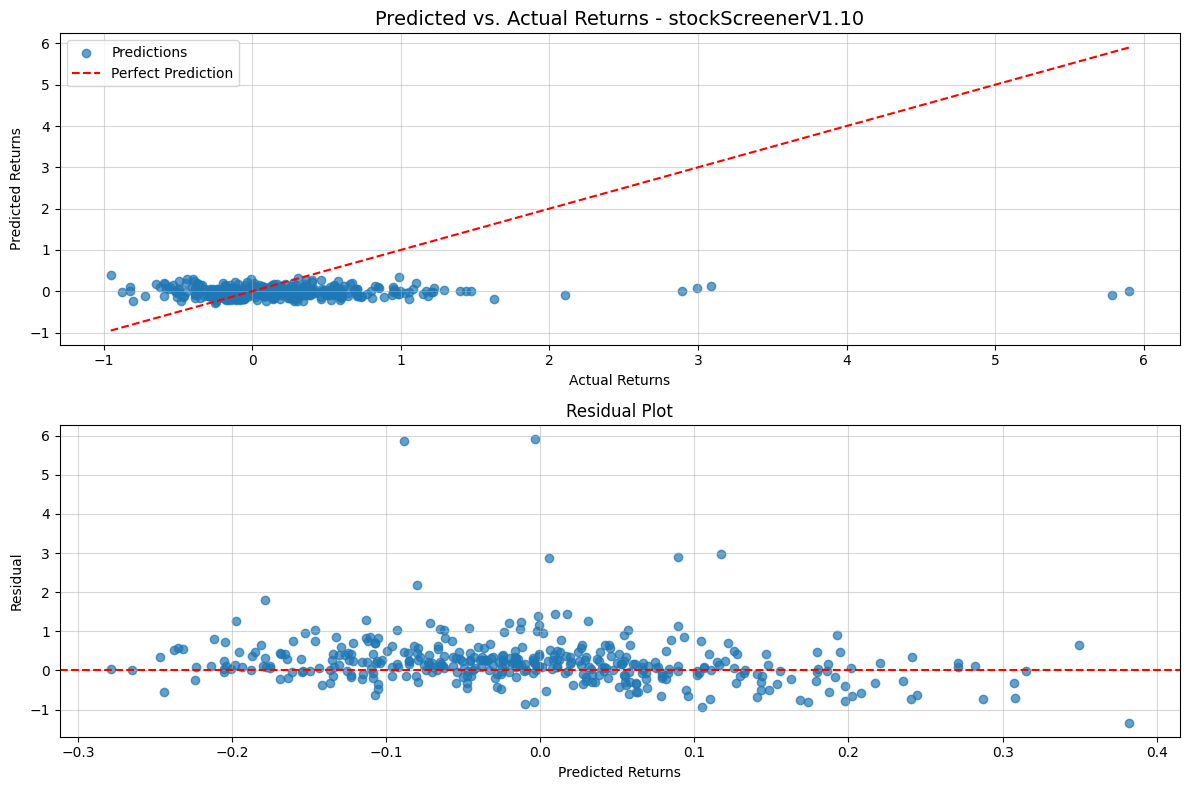

Collected 392 valid test tickers (target: 500)

Evaluation Results:
MAE: 0.405
RMSE: 0.688
R²: -0.165


In [27]:
def logEvaluation(model_name, mae, rmse, r2, model_folder, test_tickers):
    """Log evaluation metrics to CSV file"""
    log_file = model_folder / "modelEvaluations.csv"
    
    new_entry_df = pd.DataFrame([{
        "Model Name": model_name,
        "Timestamp": datetime.now().strftime('%Y-%m-%d %H:%M'),
        "MAE": f'{mae:.3f}',
        "RMSE": f'{rmse:.3f}',
        "R2": f'{r2:.3f}',
        "Epochs": epochs,
        "Training Size": trainingSize,
        "Test Size": len(test_tickers),
        "Cat Names": catNames,
        "Cont Names": contNames,
    }])
    
    try:
        log_df = pd.read_csv(log_file)
        log_df = pd.concat([log_df, new_entry_df], ignore_index=True)
    except FileNotFoundError:
        log_df = new_entry_df
        
    log_df.to_csv(log_file, index=False)
    print(f"Logged evaluation results to {log_file}")

def plotResults(results_df, model_name, model_folder):
    """Create and save visualization plots using all data points."""
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.7, label='Predictions')
    min_val = min(results_df['Actual'].min(), results_df['Predicted'].min())
    max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f'Predicted vs. Actual Returns - {model_name}', fontsize=14)
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.grid(alpha=0.5)
    
    plt.subplot(2, 1, 2)
    plt.scatter(results_df['Predicted'], results_df['Residual'], alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Predicted Returns')
    plt.ylabel('Residual')
    plt.grid(alpha=0.5)
    
    plt.tight_layout()
    plt.show()

if trainNewModel:
    nonTrainingTickers = list(set(tickers) - set(trainingTickers))
    validTestData = []
    attempted_tickers = set()
    attempts = 0

    if testSize * 4 <= len(tickers):  
        max_attempts = testSize * 4 # Prevent infinite loops
    else:
        max_attempts = len(tickers)

    # Keep trying until we reach testSize or exhaust attempts
    while len(validTestData) < testSize and attempts < max_attempts:
        # Get a new ticker we haven't tried yet
        remaining_tickers = [t for t in nonTrainingTickers if t not in attempted_tickers]
        if not remaining_tickers:  # If all tried, reset attempted list
            attempted_tickers = set()
            remaining_tickers = nonTrainingTickers
            
        ticker = np.random.choice(remaining_tickers)
        attempted_tickers.add(ticker)
        attempts += 1

        # Fetch and validate data
        data = getTickerDataFrom1YrAgo(ticker)
        if not data.empty and not data[['EV/EBIT', 'ROIC']].isna().any().any():
            validTestData.append(data)

    if not validTestData:
        raise ValueError("No valid test data collected after multiple attempts")
        
    # Trim to exact testSize if we collected more
    validTestData = validTestData[:testSize]  
    combinedTestData = pd.concat(validTestData, ignore_index=True)

    # Clean data
    test_data_clean = combinedTestData.dropna(subset=['EV/EBIT', 'ROIC', 'Future Year Change'])
    
    if test_data_clean.empty:
        raise ValueError("No valid test data after cleaning NaN values")

    # Create test dataloader
    test_dl = learn.dls.test_dl(test_data_clean)
    preds, targs = learn.get_preds(dl=test_dl)
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Predicted': preds.numpy().flatten(),
        'Actual': targs.numpy().flatten()
    })
    results_df['Residual'] = results_df['Actual'] - results_df['Predicted']

    # Calculate metrics
    mae = np.mean(np.abs(results_df['Residual']))
    rmse = np.sqrt(np.mean(results_df['Residual']**2))
    r2 = 1 - (np.sum(results_df['Residual']**2) / np.sum((results_df['Actual'] - results_df['Actual'].mean())**2))

    # Log and plot
    logEvaluation(modelName, mae, rmse, r2, modelFolder, test_data_clean['Ticker'].unique())
    plotResults(results_df, modelName, modelFolder)

    # Show collection stats
    print(f"Collected {len(validTestData)} valid test tickers (target: {testSize})")
    if attempts >= max_attempts:
        print(f"Warning: Reached max attempts ({max_attempts}). Some invalid tickers may remain.")  
    print(f"\nEvaluation Results:")
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")

## Predictions

In [28]:
print('Model files in modelFolder:')
for file in modelFolder.glob('*.pkl'):
    print(file.name)

Model files in modelFolder:
stockScreenerV1.0.pkl
stockScreenerV1.1.pkl
stockScreenerV1.10.pkl
stockScreenerV1.2.pkl
stockScreenerV1.3.pkl
stockScreenerV1.4.pkl
stockScreenerV1.5.pkl
stockScreenerV1.6.pkl
stockScreenerV1.7.pkl
stockScreenerV1.8.pkl
stockScreenerV1.9.pkl


In [29]:
evaluations = pd.read_csv(modelFolder / 'modelEvaluations.csv')
bestModel = evaluations.sort_values('MAE', ascending=True).iloc[0]
bestModel.head()

Model Name    stockScreenerV1.7
Timestamp      2025-01-27 08:45
MAE                       0.328
RMSE                      0.739
R2                        0.077
Name: 7, dtype: object

### Load model

In [30]:
if os.name == 'nt':
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
else:
    pathlib.WindowsPath = pathlib.PosixPath

importedModel = Path(f"{bestModel['Model Name']}.pkl") # Change this if you want to try other models
learn = load_learner(modelFolder / importedModel)

In [31]:
#predictionTarget = '95%'

In [32]:
if predictionTarget != 'None':
    if predictionTarget == 'ALL':
        predictionTickers = tickers
    elif predictionTarget.endswith('%'):
        percentage = float(predictionTarget.strip('%')) / 100
        num_tickers = int(len(tickers) * percentage)
        predictionTickers = np.random.choice(tickers, size=num_tickers, replace=False).tolist()
    else:
        predictionTickers = [predictionTarget]

    # Fetch data for prediction tickers
    dfPrediction = pd.concat([getTickerData(ticker) for ticker in predictionTickers], ignore_index=True)

    # Ensure dfPrediction is a DataFrame
    if isinstance(dfPrediction, dict):
        dfPrediction = pd.DataFrame([dfPrediction])

    # Drop rows with NaN values in 'EV/EBIT' or 'ROIC'
    dfPrediction = dfPrediction.dropna(subset=['EV/EBIT', 'ROIC'])

    # Create test dataloader
    dl = learn.dls.test_dl(dfPrediction)
    dfPrediction.head()

    # Make predictions
    prediction = learn.get_preds(dl=dl)
    adr_df = pd.read_csv(testFolder / 'tickers.csv')
    company_dict = dict(zip(adr_df['Ticker'], adr_df['Company']))

    if predictionTarget == 'ALL' or predictionTarget.endswith('%'):
        sorted_predictions = sorted(zip(predictionTickers, prediction[0]), key=lambda x: x[1], reverse=True)
        print(f"Got predictions for {len(sorted_predictions)} tickers, expected: {len(predictionTickers)}")
        print(f"Prediction for best performing tickers:")
        for symbol, pred in sorted_predictions:
            company_name = company_dict.get(symbol, 'Unknown')
            print(f"{symbol} ({company_name}): {pred[0].item() * 100:.2f}%")
    else:
        company_name = company_dict.get(predictionTarget, 'Unknown')
        print(f"Prediction for {predictionTarget} ({company_name}):")
        print(f"{prediction[0][0][0].item() * 100:.2f}%")
    print("Free money?!")

Prediction for NVO (Novo Nordisk A/S):
12.48%
Free money?!
